In [65]:
# importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectCompletedata.csv')
print(dataset)

       Province/State        Country/Region          Lat         Long  \
0                 NaN           Afghanistan  33.93911000  67.70995300   
1                 NaN               Albania  41.15330000  20.16830000   
2                 NaN               Algeria  28.03390000   1.65960000   
3                 NaN               Andorra  42.50630000   1.52180000   
4                 NaN                Angola -11.20270000  17.87390000   
...               ...                   ...          ...          ...   
307491            NaN    West Bank and Gaza  31.95220000  35.23320000   
307492            NaN  Winter Olympics 2022  39.90420000 116.40740000   
307493            NaN                 Yemen  15.55272700  48.51638800   
307494            NaN                Zambia -13.13389700  27.84933200   
307495            NaN              Zimbabwe -19.01543800  29.15485700   

            Date  Confirmed  Deaths  Recovered  Active  
0        1/22/20          0       0          0       0  
1        

In [67]:
#Changing column names
dataset = dataset.rename(columns={"Province/State":"State","Country/Region": "Country"})
dataset["Date"] = pd.to_datetime(dataset["Date"])

In [68]:
dataset_India = dataset.loc[dataset['Country'] == 'India']
dataset_India

,State,Country,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
148,NaN,India,20.59368400,78.96288000,2020-01-22,0,0,0,0
437,NaN,India,20.59368400,78.96288000,2020-01-23,0,0,0,0
726,NaN,India,20.59368400,78.96288000,2020-01-24,0,0,0,0
1015,NaN,India,20.59368400,78.96288000,2020-01-25,0,0,0,0
1304,NaN,India,20.59368400,78.96288000,2020-01-26,0,0,0,0
...,...,...,...,...,...,...,...,...,...
306199,NaN,India,20.59368400,78.96288000,2022-12-16,44676999,530667,0,44146332
306488,NaN,India,20.59368400,78.96288000,2022-12-17,44677175,530672,0,44146503
306777,NaN,India,20.59368400,78.96288000,2022-12-18,44677310,530674,0,44146636
307066,NaN,India,20.59368400,78.96288000,2022-12-19,44677422,530677,0,44146745


In [69]:
#New Data set 
timeseries_df_India = dataset_India.filter(["Date",  "Confirmed", "Deaths", "Recovered", "Active"])
timeseries_df_India = timeseries_df_India.groupby(timeseries_df_India["Date"]).sum()
timeseries_df_India
# Select the proper time period for weekly aggreagation
timeseries_df_India = timeseries_df_India['2020-01-22':'2022-12-20'].resample('W').sum()
timeseries_df_India

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-01-26,0,0,0,0
2020-02-02,5,0,0,5
2020-02-09,21,0,0,21
2020-02-16,21,0,3,18
2020-02-23,21,0,21,0
...,...,...,...,...
2022-11-27,312704303,3714226,0,308990077
2022-12-04,312718709,3714366,0,309004343
2022-12-11,312729215,3714541,0,309014674


#**CONFIRMED CASES**

Creating a line plot for the full time series of Confirmed Cases. Here plot() function form matplotlib package is used. Tried looking into the trend by plotting the original data alon with other line which is aggregated by the mean for monthly data. So we can find visualisation for line plot with two lines in it. 






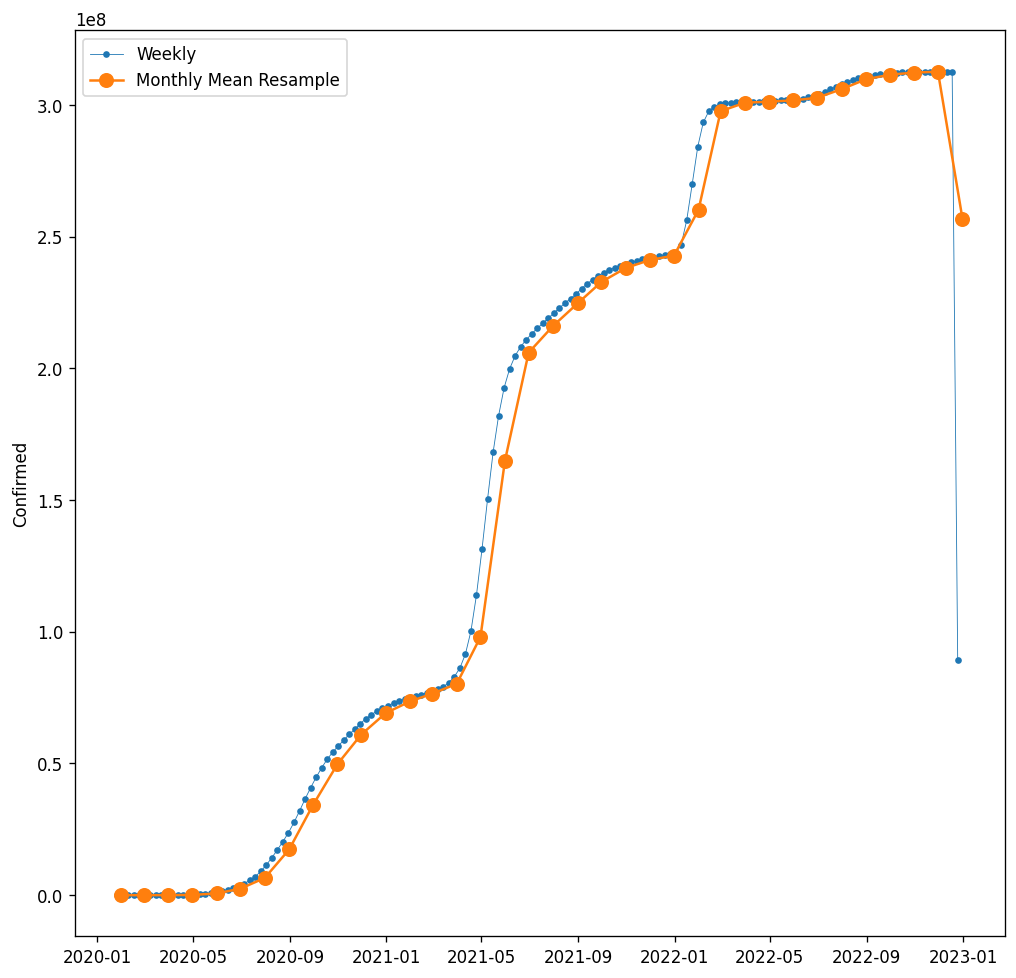

In [70]:
y = timeseries_df_India['Confirmed']
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Confirmed')
ax.legend();

The line graph is plotted with Confirmed cases aggregatd for weekly and monthly along with date. If we look into the graph we can observe upward/downward trends in the data along with few anomalies. As there is no data included after December 20th, 2022 we can see a dip at the end of the line.

* Decomposition of the time series: 
The following properties will be observed from data decomposition.
*Trend: It can be seen as a slope with increase or decrease in the data.
* Sesonality: It is observed as patterns with a frequency which is affected by time period.
* Residuals: It is observed as the diffrence between obereved and predicted time series at each at a time t.



In [71]:
# graphs to show seasonal_decompose
def seasonal_decompose_func (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(8,8)
    plt.show()

Calling the function seasonal_decompose() which is created above by passing the time series as an input to the function.

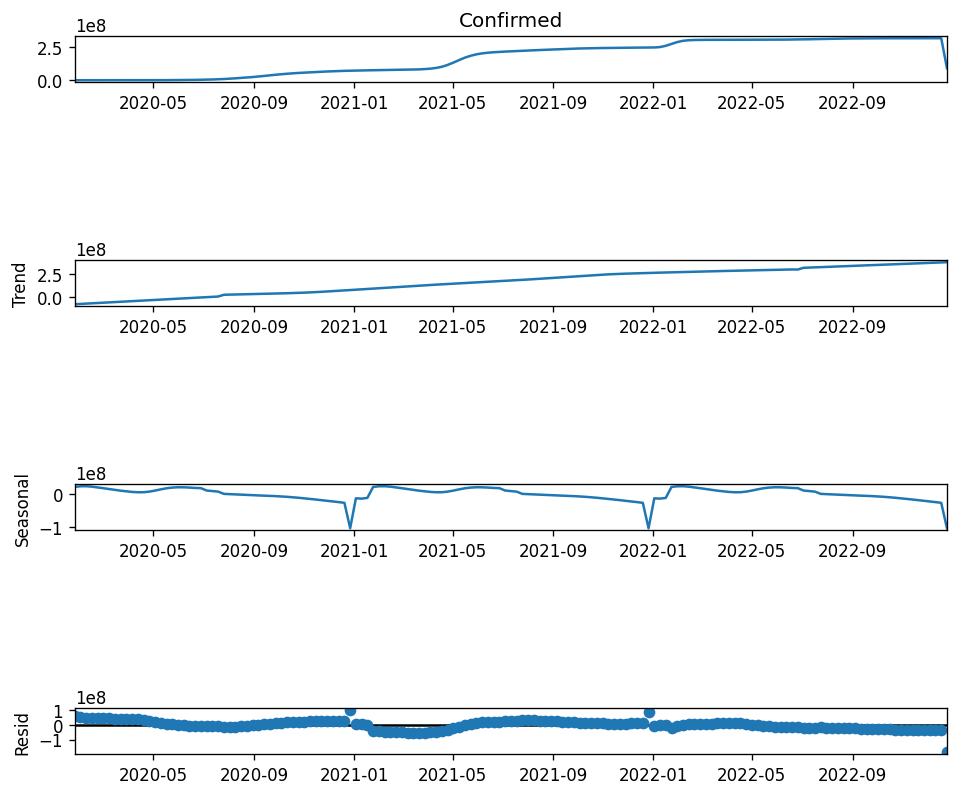

In [72]:
seasonal_decompose_func(y)

From the 4 graphs the first graph indicates the plotting of obserevd series and 2nd graph is for Trend, 3rd is for Sesionality and 4th is for Residuals. Additive model decomposition is chosen for this dataset.From the resultant trend graph it can be observed that there is an upward trend. Also in the sesonal graph we can observe that there is a sesonality for every start of the year.The residuals or the errors are also spread randomly in the Resid graph. By determing these properties of series will be helpful in choosing the time series models.

* **STATIONARITY CHECK**: 
The observations in a stationary time series are not dependent on time.
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.


* Rolling statistics test: if time series data is required to be stationary the it should have a constant mean and variance. This indicates the mean and standard deviation or square root of variance are constant with increase in time. The rolling statistics is one of the visualisation method to visulaise the mean and standard deviation of the data.

In [73]:
### plot for Rolling Statistic for testing Stationarity
def stationarity_test(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    plt.title("Rolling mean and standard deviation")
    ax.legend()

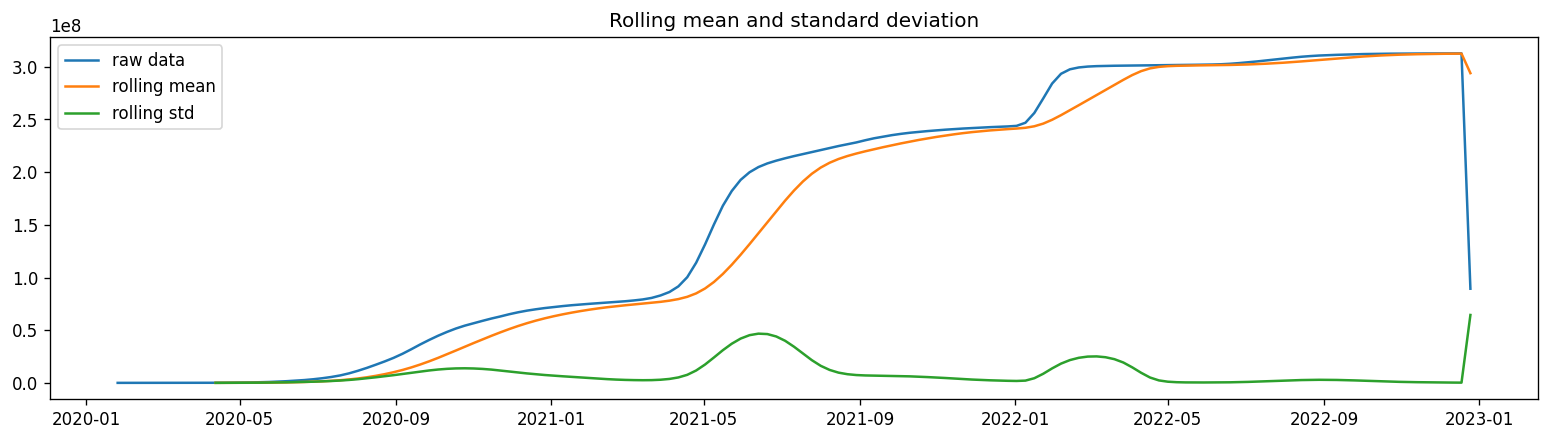

In [74]:
pd.options.display.float_format = '{:.8f}'.format
stationarity_test(y,'raw data')

After plotting the rolling statistics for the Time series data, from the resultant graph it can be observed as the rolling mean is incerasing with the increase in time and rolling standard deviation is constant with time. This indicates that the time series which we are analysing is not stationary.

* Augmented Dickey-Fuller Test:
The main reson behind conducting this test is to determing the stationarity. Here p-value <=0.05 then we can say that the null hypothesis is rejected and the data is stationary. If p-value >0.05 then it failed to reject the hypothesis and the data is not stationary.




In [75]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [76]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.257
P-value = 0.649
Critical values :
	1%: -3.4744158894942156 - The data is not stationary with 99% confidence
	5%: -2.880878382771059 - The data is not stationary with 95% confidence
	10%: -2.577081275821236 - The data is not stationary with 90% confidence


From the output we can observe that the p-value > 0.05 and also the test statistic when compared to the critical values the test statistic value is greater. So the time series data which we used for analysis is not stationary.

* **Making the data stationary**

* Taking square root of the data: As the data for the confirmed cases are too large in numbers so taking square roo to those values.

In [77]:
df_sqrt=np.sqrt(timeseries_df_India['Confirmed'])
df_diff=df_sqrt.diff().dropna()
print(df_diff)

Date
2020-02-02       2.23606798
2020-02-09       2.34650772
2020-02-16       0.00000000
2020-02-23       0.00000000
2020-03-01       0.00000000
                  ...      
2022-11-27       0.61858365
2022-12-04       0.40732539
2022-12-11       0.29704813
2022-12-18       0.24199469
2022-12-25   -8231.61741501
Freq: W-SUN, Name: Confirmed, Length: 152, dtype: float64


In [78]:
# Using drop() function to delete last row
df_diff.drop(index=df_diff.index[-1],axis=0,inplace=True)
print(df_diff)
y = df_diff

Date
2020-02-02   2.23606798
2020-02-09   2.34650772
2020-02-16   0.00000000
2020-02-23   0.00000000
2020-03-01   0.00000000
                ...    
2022-11-20   1.06880927
2022-11-27   0.61858365
2022-12-04   0.40732539
2022-12-11   0.29704813
2022-12-18   0.24199469
Freq: W-SUN, Name: Confirmed, Length: 151, dtype: float64


* Deseasonalising: It removes the underlying seasonaity from the time series. 

 > Is the de-seasonalized data stationary ?
Test statistic = -8.348
P-value = 0.000
Critical values :
	1%: -3.4753253063120644 - The data is  stationary with 99% confidence
	5%: -2.881274703275226 - The data is  stationary with 95% confidence
	10%: -2.5772928360116873 - The data is  stationary with 90% confidence


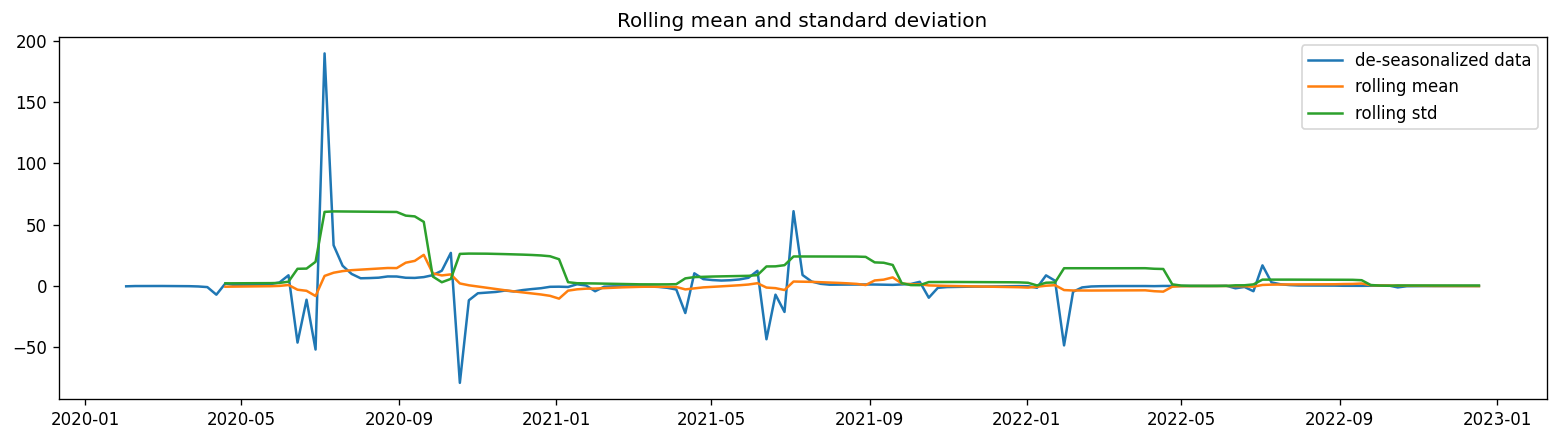

In [79]:
# Deseasonalize
result_add = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
deseasonlize = y.values / result_add.seasonal
# rolling statistics test
stationarity_test(deseasonlize,'de-seasonalized data')
#ADF test
ADF_test(deseasonlize,'de-seasonalized data')

From the plots we can observe that the mean and standard deviation had become constant with time and the test statistic values are also greater than the critical calues. So we can conclude from this that the time series data had become stationary after removing the sesonal component

**ARIMA**:
ARIMA is an Auto Regressive Integrated Moving Average.
It is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. ARIMA model accepts the non-sesasonal time series. So for this model we are removing the seasonality by taking the deseasonal time series which are computed above.

* Finding order of differencing(d) in ARIMA model: The purpose of differencing it to make the time series stationary.

But we need to be careful to not over-difference the series. Because, an over differenced series may still be non-stationary, which in turn will affect the model parameters.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing.



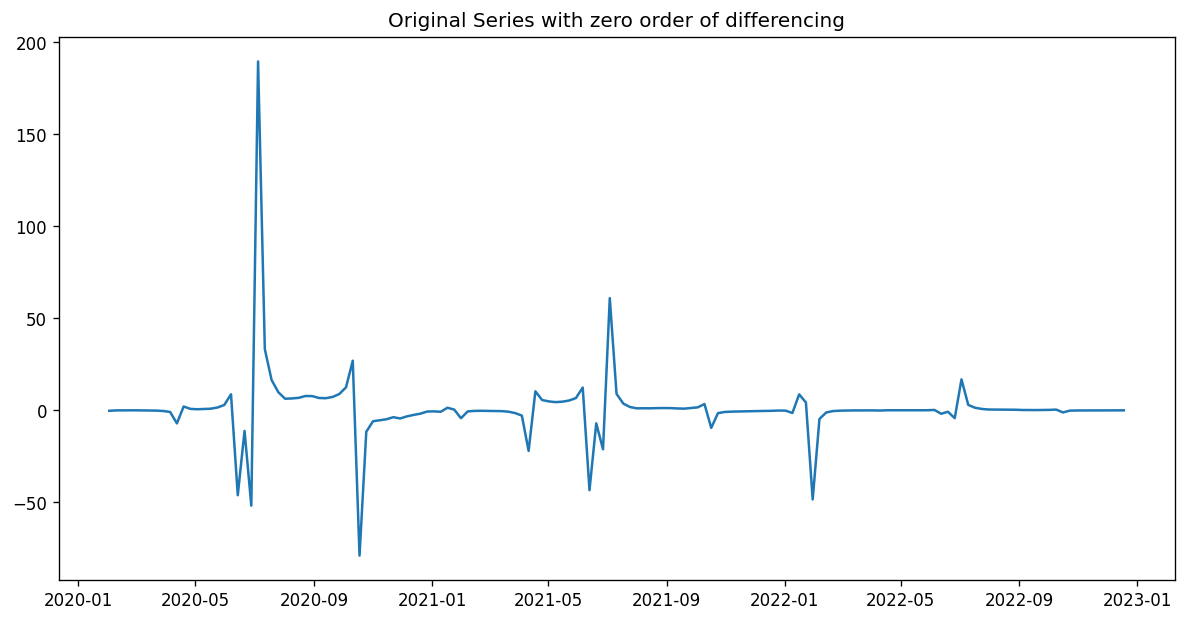

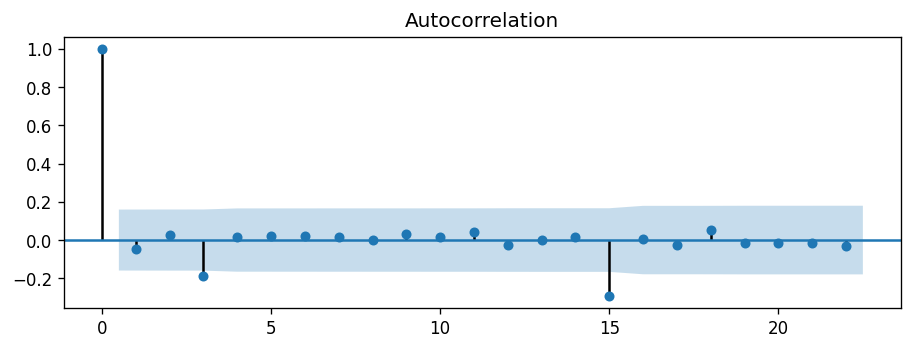

In [80]:
# Original Series
y_deseasonal = deseasonlize
plt.figure(figsize=(12, 6))
plt.plot(y_deseasonal)
plt.title('Original Series with zero order of differencing')
acf0 = plot_acf(y_deseasonal)

From the resultant plots we can observe that the ACF plot reaches to 0 at the zero order difference itself. So we are considering d value which is orderof diffrencing as d = 0 for this time series.

* Deternming AR(p)

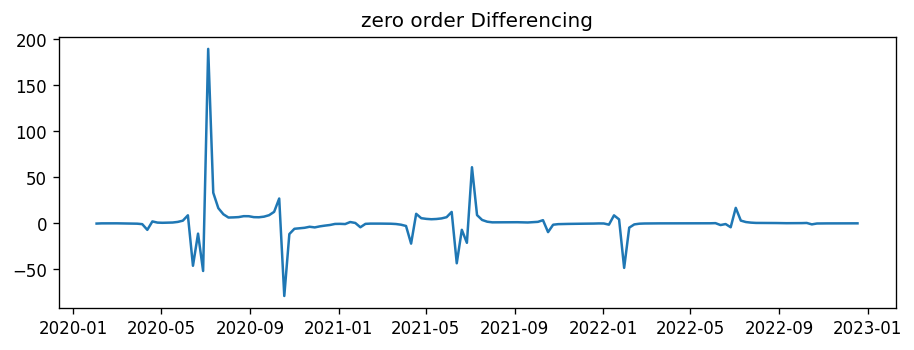

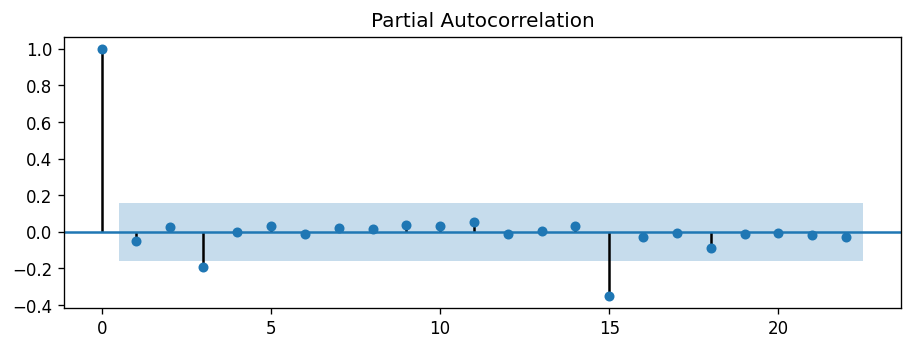

In [81]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
pacf = plot_pacf(y_deseasonal.dropna())

* Determining MA(q)

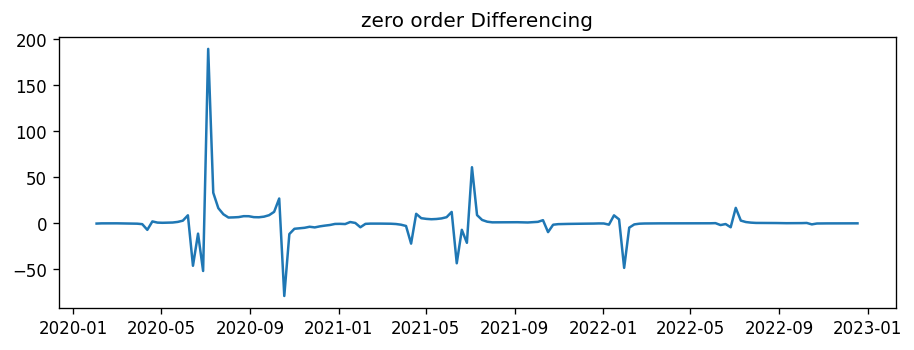

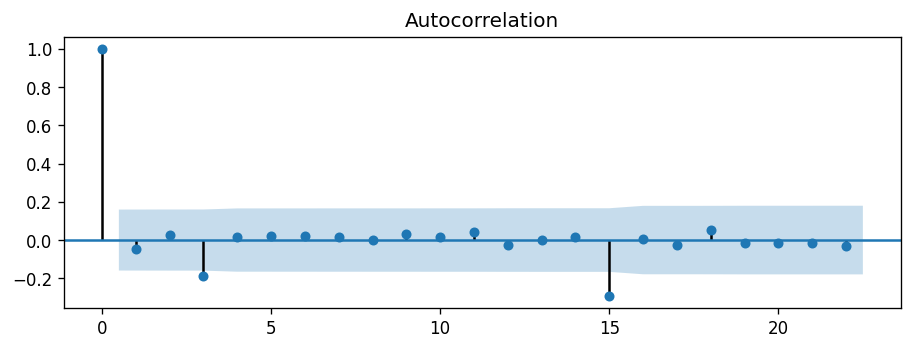

In [82]:
plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
acf = plot_acf(y_deseasonal.dropna())

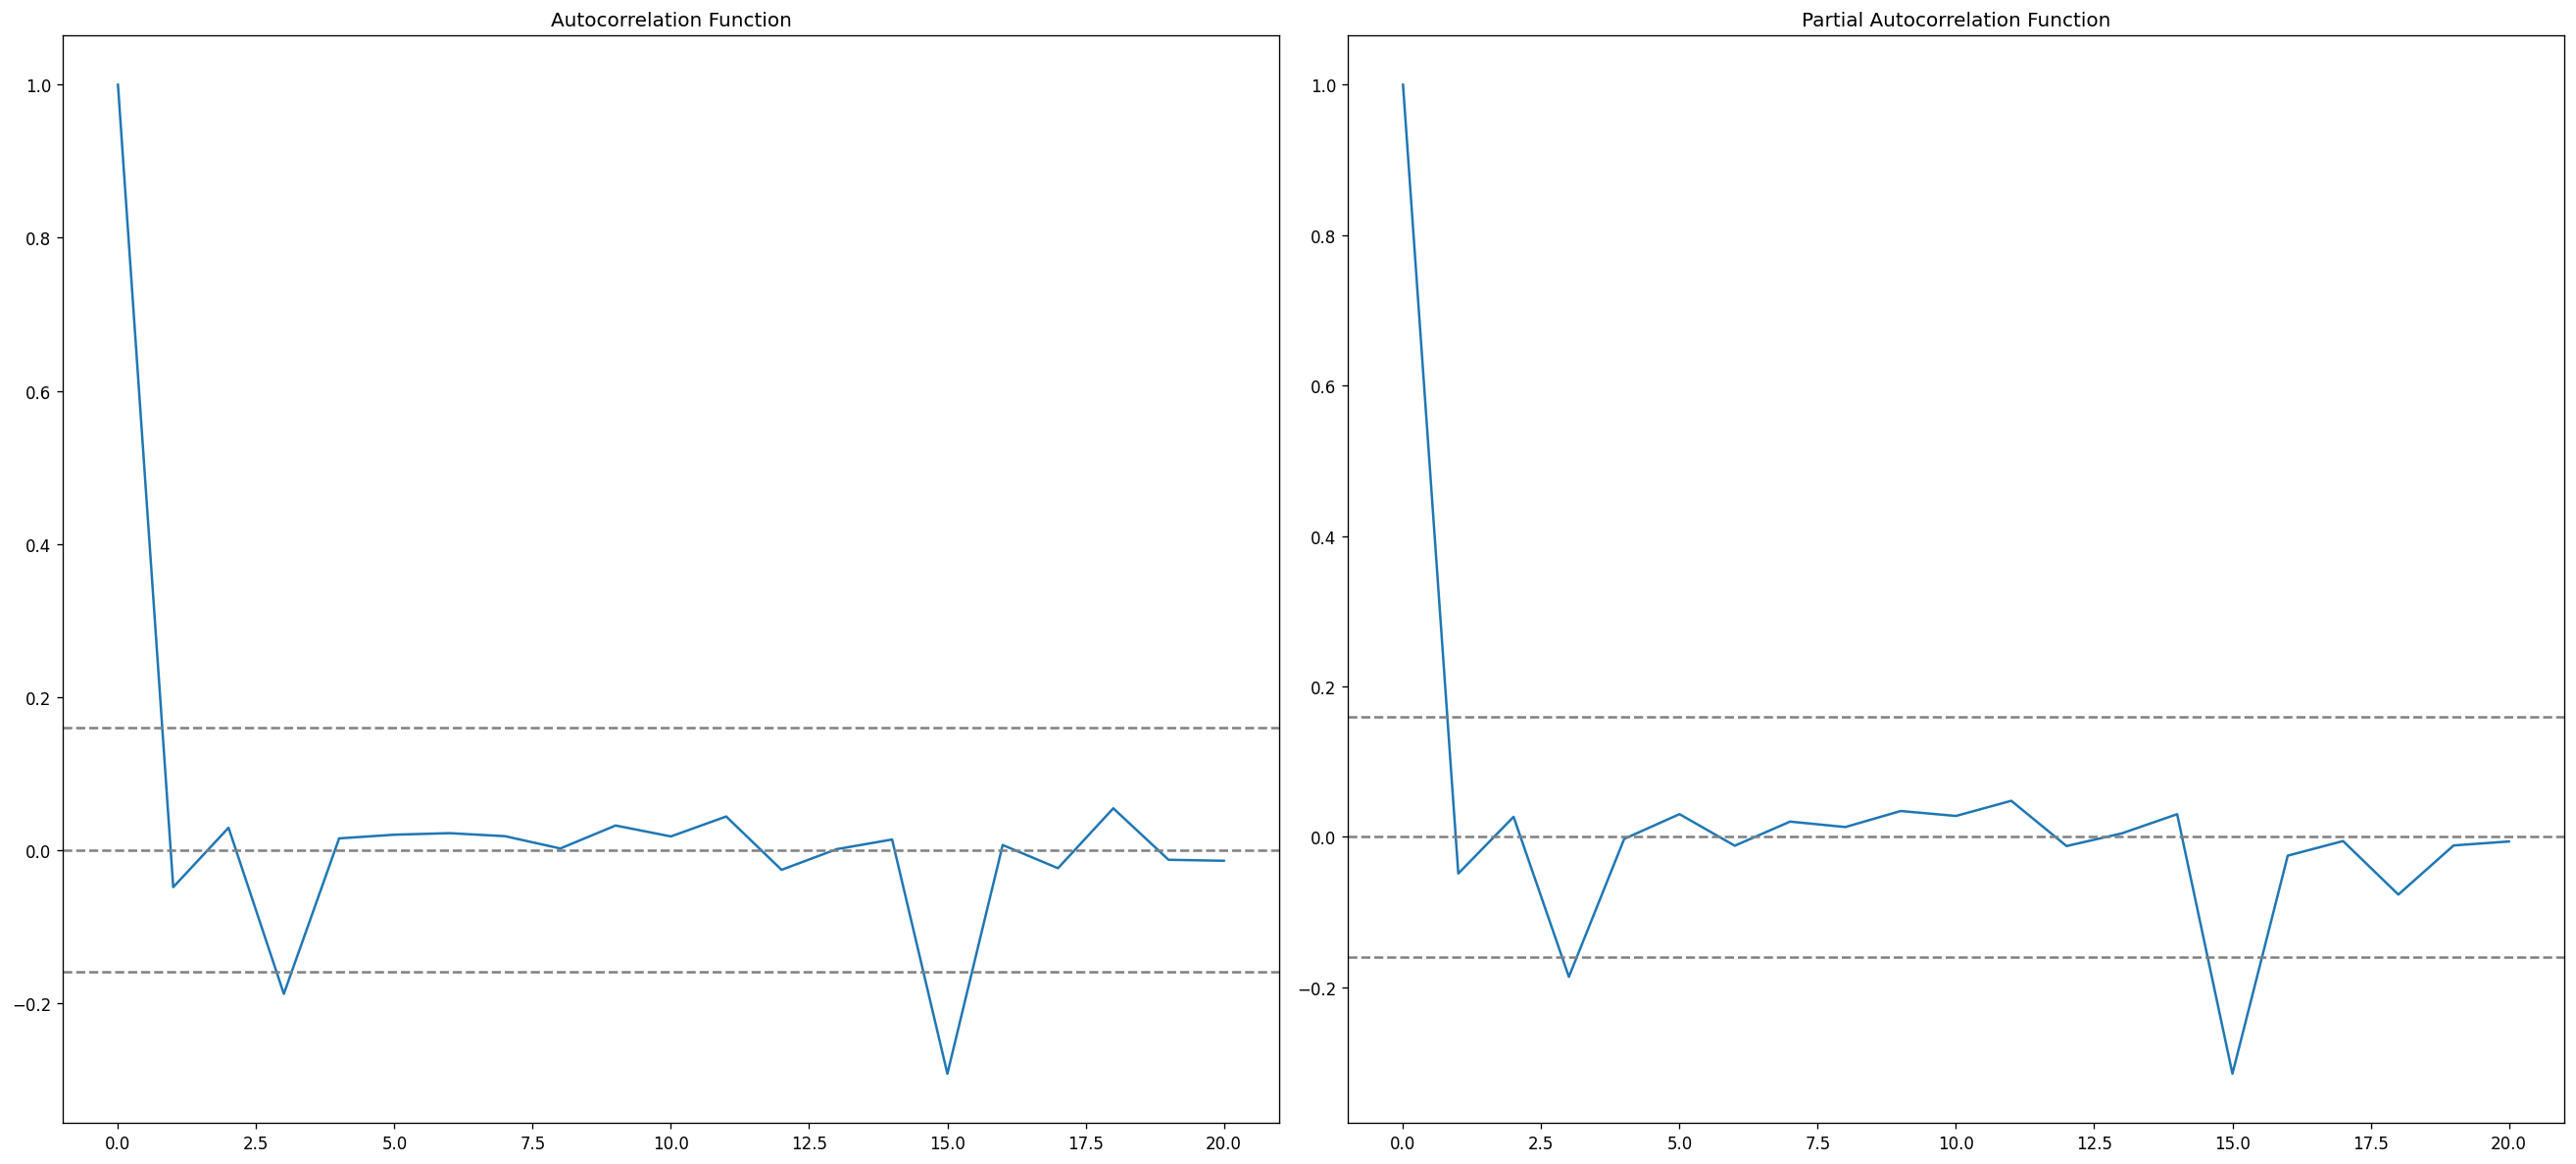

In [83]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(y_deseasonal, nlags=20)
lag_pacf = pacf(y_deseasonal, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values
Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time which is close to 1. p=1.
Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time which is close to 1. q=1.

In [84]:
model = ARIMA(y_deseasonal, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               seasonal   No. Observations:                  151
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -665.678
Date:                Tue, 17 Jan 2023   AIC                           1339.357
Time:                        07:47:04   BIC                           1351.426
Sample:                    02-02-2020   HQIC                          1344.260
                         - 12-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8482      2.116      0.401      0.689      -3.300       4.996
ar.L1         -0.7989      0.684     -1.167      0.243      -2.140       0.542
ma.L1          0.7363      0.712      1.034      0.3

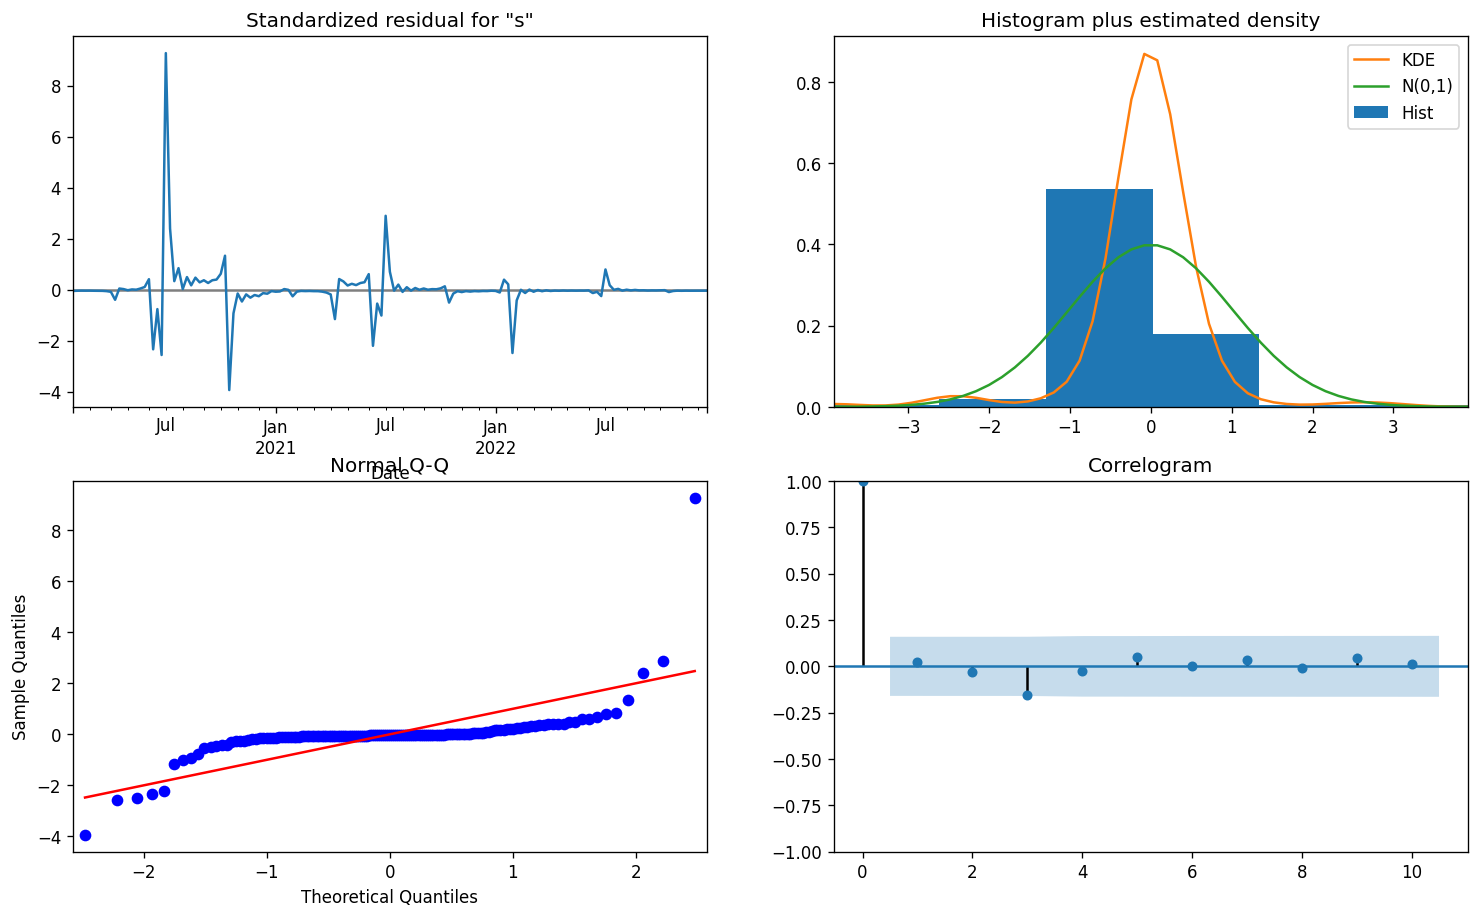

In [85]:
residuals_default = model_fit.plot_diagnostics(figsize=(15, 9))

* One-step ahead forecast

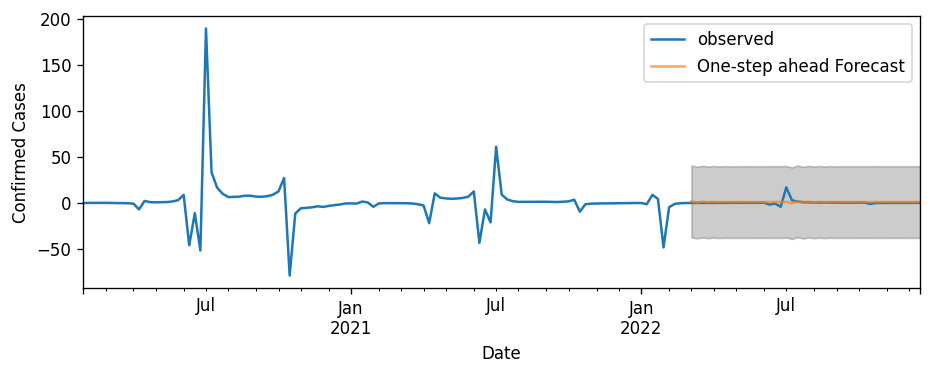

In [86]:
# Validating forecasts
# To help us understand the accuracy of our forecasts, 
# we compare predicted sales to real sales of the time series, and we set forecasts 
# to start at 2022-03-06 to the end of the data.
pred = model_fit.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_deseasonal.loc[:][:].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases')
plt.legend()
plt.show()
# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts slightly differs with the true values, but shows a downward trend starts from the 
# 1st quarter of the year and captured the seasonality toward the end of the year.

* Future confirmed cases forecasting with ARIMA model

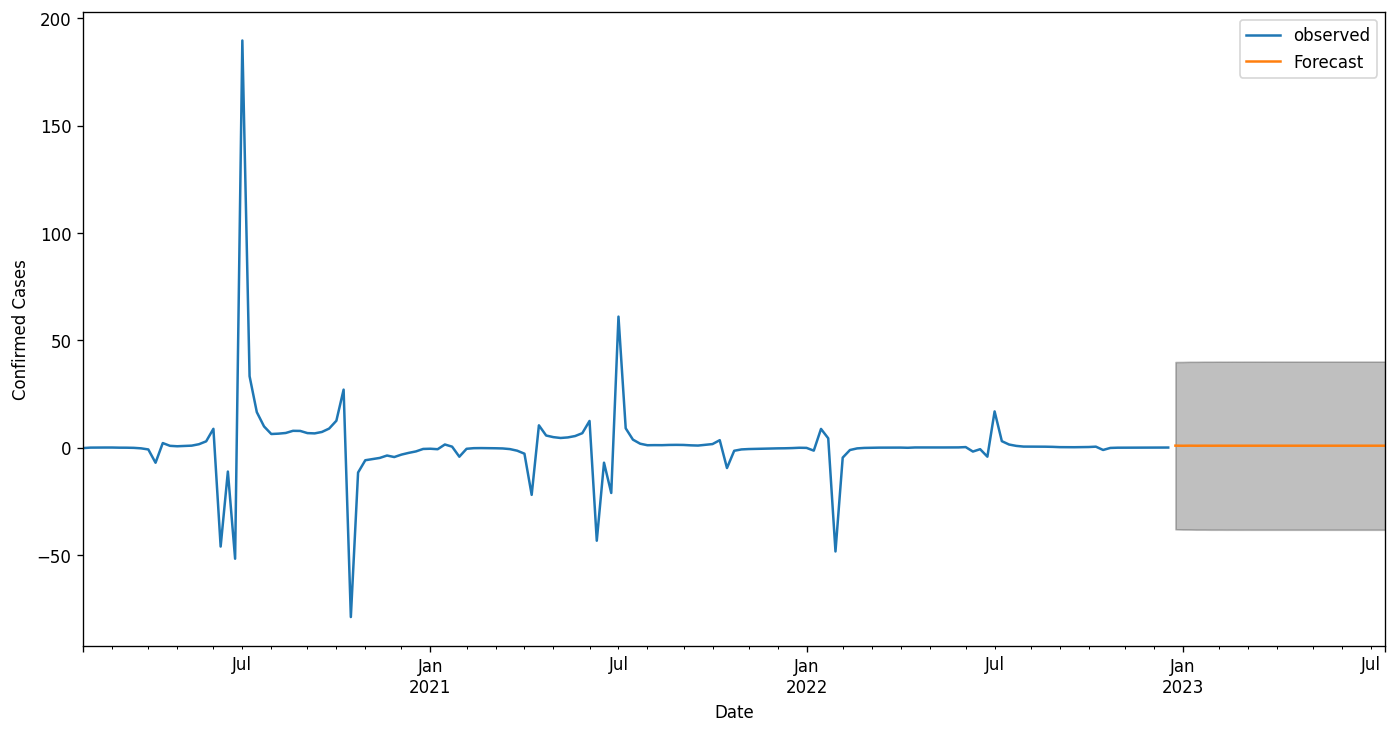

In [87]:
pred_uc = model_fit.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y_deseasonal.loc['2020-02-02':][:].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [88]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-12-25,0.87364998,-38.08004937,39.82734934
1,2023-01-01,0.82780994,-38.20205830,39.85767818
2,2023-01-08,0.86442948,-38.21396978,39.94282874
3,2023-01-15,0.83517578,-38.27416300,39.94451456
4,2023-01-22,0.85854524,-38.27052539,39.98761587
5,2023-01-29,0.83987644,-38.30178125,39.98153412
6,2023-02-05,0.85479010,-38.29489814,40.00447834
7,2023-02-12,0.84287625,-38.31193599,39.99768848
8,2023-02-19,0.85239369,-38.30568817,40.01047554
9,2023-02-26,0.84479063,-38.31537765,40.00495892


#**DEATH CASES**

Creating a line plot for the full time series of Death Cases. Here plot() function form matplotlib package is used. Tried looking into the trend by plotting the original data alon with other line which is aggregated by the mean for monthly data. So we can find visualisation for line plot with two lines in it. 






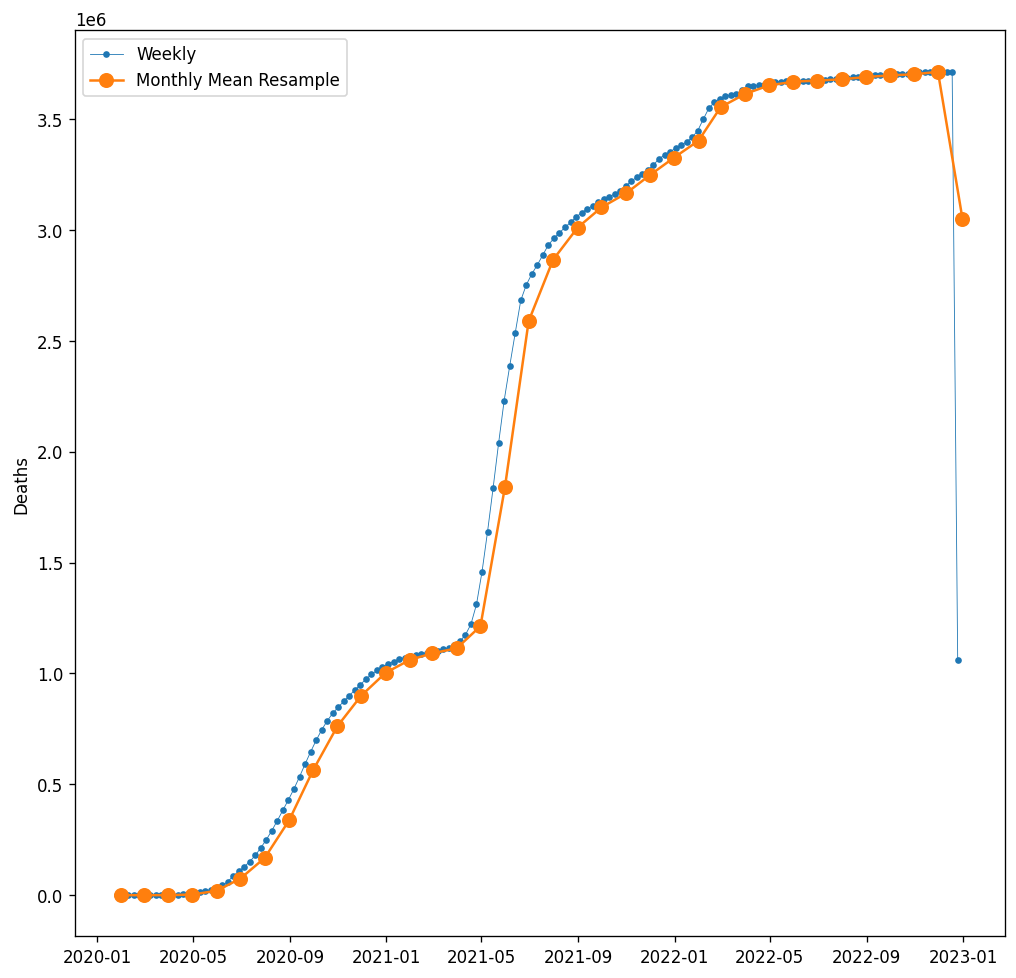

In [89]:
y = timeseries_df_India['Deaths']
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Deaths')
ax.legend();

The line graph is plotted with Death cases aggregatd for weekly and monthly along with date. If we look into the graph we can observe upward/downward trends in the data along with few anomalies. As there is no data included after December 20th, 2022 we can see a dip at the end of the line.

* Decomposition of the time series: 
The following properties will be observed from data decomposition.
*Trend: It can be seen as a slope with increase or decrease in the data.
* Sesonality: It is observed as patterns with a frequency which is affected by time period.
* Residuals: It is observed as the diffrence between obereved and predicted time series at each at a time t.



In [90]:
# graphs to show seasonal_decompose
def seasonal_decompose_func (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(8,8)
    plt.show()

Calling the function seasonal_decompose() which is created above by passing the time series as an input to the function.

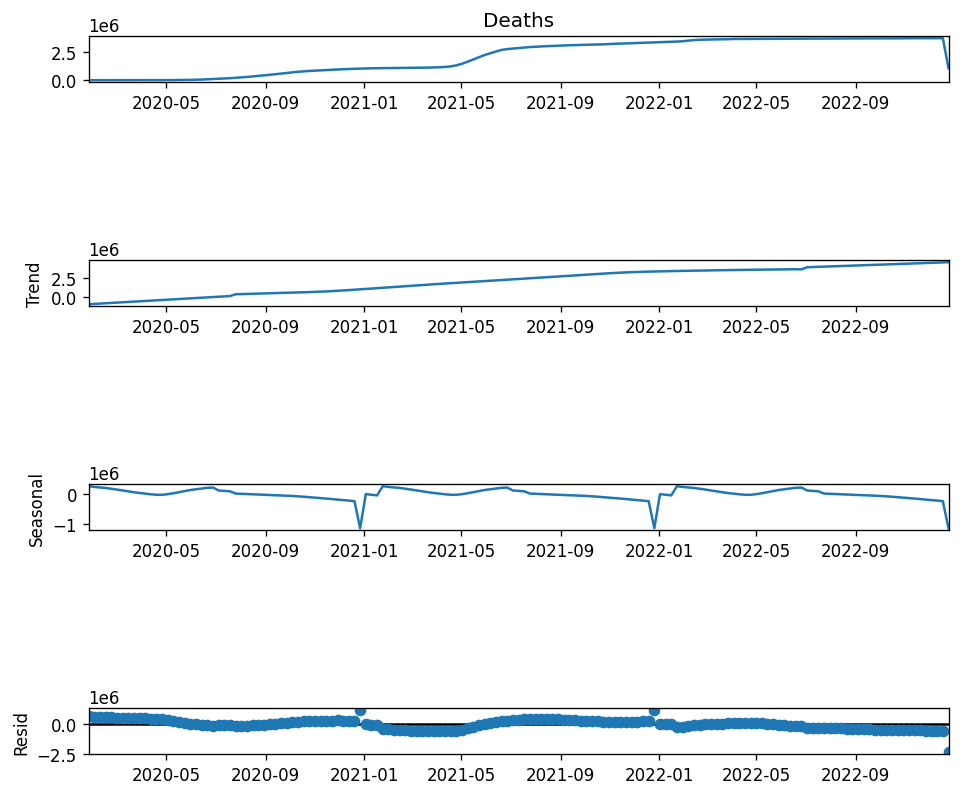

In [91]:
seasonal_decompose_func(y)

From the 4 graphs the first graph indicates the plotting of obserevd series and 2nd graph is for Trend, 3rd is for Sesionality and 4th is for Residuals. Additive model decomposition is chosen for this dataset.From the resultant trend graph it can be observed that there is an upward trend. Also in the sesonal graph we can observe that there is a sesonality for every start of the year.The residuals or the errors are also spread randomly in the Resid graph. By determing these properties of series will be helpful in choosing the time series models.

* **STATIONARITY CHECK**: 
The observations in a stationary time series are not dependent on time.
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.


* Rolling statistics test: if time series data is required to be stationary the it should have a constant mean and variance. This indicates the mean and standard deviation or square root of variance are constant with increase in time. The rolling statistics is one of the visualisation method to visulaise the mean and standard deviation of the data.

In [92]:
### plot for Rolling Statistic for testing Stationarity
def stationarity_test(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    plt.title("Rolling mean and standard deviation")
    ax.legend()

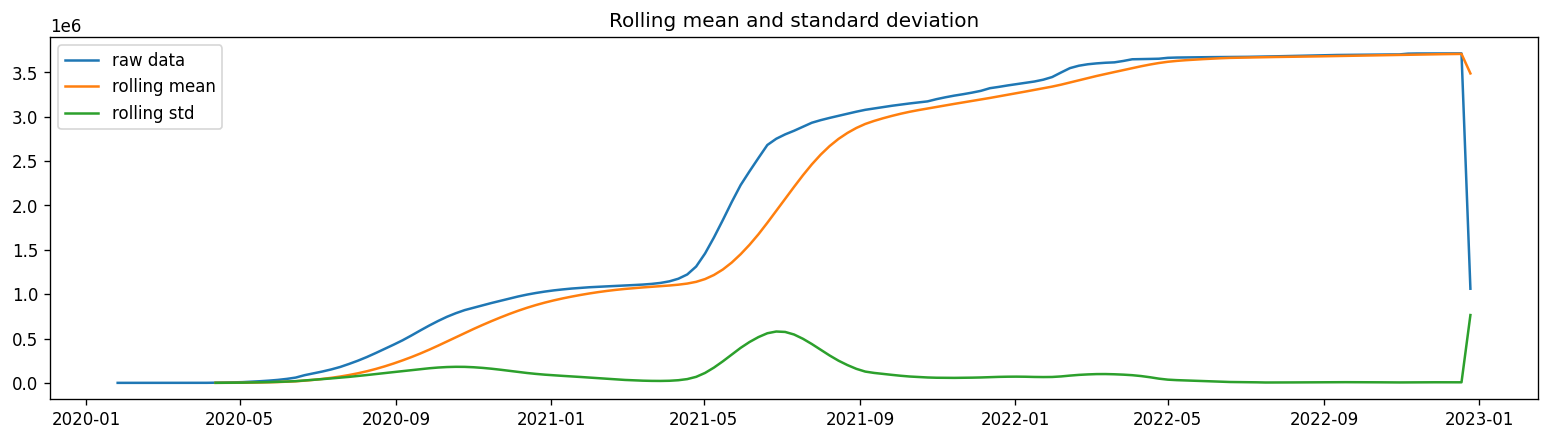

In [93]:
pd.options.display.float_format = '{:.8f}'.format
stationarity_test(y,'raw data')

After plotting the rolling statistics for the Time series data, from the resultant graph it can be observed as the rolling mean is incerasing with the increase in time and rolling standard deviation is constant with time. This indicates that the time series which we are analysing is not stationary.

* Augmented Dickey-Fuller Test:
The main reson behind conducting this test is to determing the stationarity. Here p-value <=0.05 then we can say that the null hypothesis is rejected and the data is stationary. If p-value >0.05 then it failed to reject the hypothesis and the data is not stationary.




In [94]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [95]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.115
P-value = 0.709
Critical values :
	1%: -3.4744158894942156 - The data is not stationary with 99% confidence
	5%: -2.880878382771059 - The data is not stationary with 95% confidence
	10%: -2.577081275821236 - The data is not stationary with 90% confidence


From the output we can observe that the p-value > 0.05 and also the test statistic when compared to the critical values the test statistic value is greater. So the time series data which we used for analysis is not stationary.

* **Making the data stationary**

* Taking square root of the data: As the data for the death cases are too large in numbers so taking square roo to those values.

In [96]:
df_log=np.sqrt(timeseries_df_India['Deaths'])
df_diff=df_log.diff().dropna()
print(df_diff)

Date
2020-02-02      0.00000000
2020-02-09      0.00000000
2020-02-16      0.00000000
2020-02-23      0.00000000
2020-03-01      0.00000000
                  ...     
2022-11-27      0.08535744
2022-12-04      0.03632117
2022-12-11      0.04540050
2022-12-18      0.02957460
2022-12-25   -897.12220664
Freq: W-SUN, Name: Deaths, Length: 152, dtype: float64


In [97]:
# Using drop() function to delete last row
df_diff.drop(index=df_diff.index[-1],axis=0,inplace=True)
print(df_diff)
y = df_diff

Date
2020-02-02   0.00000000
2020-02-09   0.00000000
2020-02-16   0.00000000
2020-02-23   0.00000000
2020-03-01   0.00000000
                ...    
2022-11-20   0.06719894
2022-11-27   0.08535744
2022-12-04   0.03632117
2022-12-11   0.04540050
2022-12-18   0.02957460
Freq: W-SUN, Name: Deaths, Length: 151, dtype: float64


* Deseasonalising: It removes the underlying seasonaity from the time series. 

 > Is the de-seasonalized data stationary ?
Test statistic = -4.512
P-value = 0.000
Critical values :
	1%: -3.4753253063120644 - The data is  stationary with 99% confidence
	5%: -2.881274703275226 - The data is  stationary with 95% confidence
	10%: -2.5772928360116873 - The data is  stationary with 90% confidence


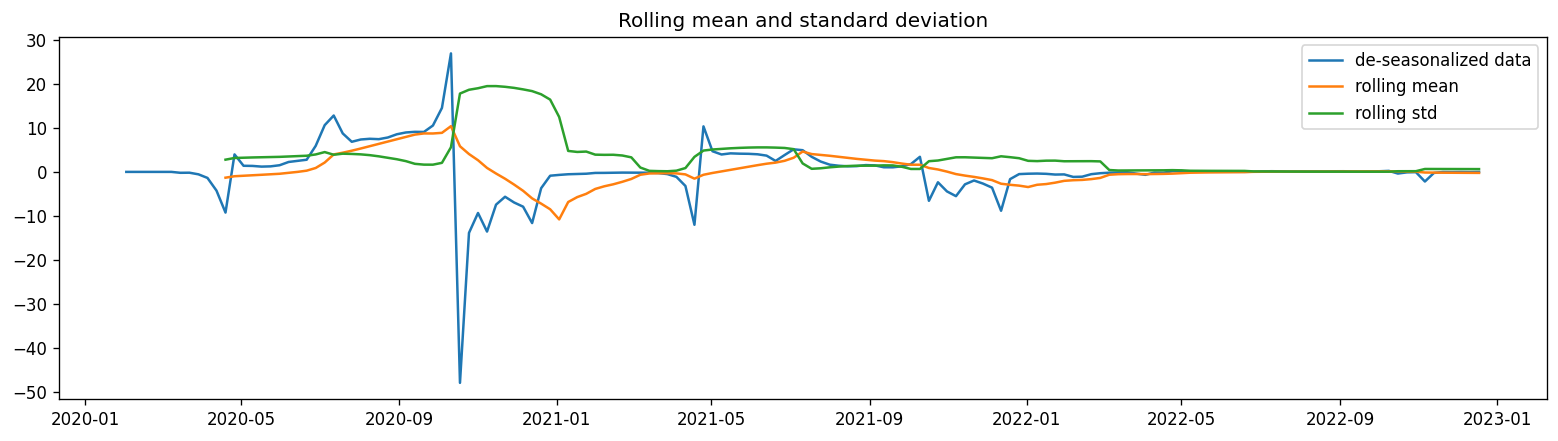

In [98]:
# Deseasonalize
result_add = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
deseasonlize = y.values / result_add.seasonal
# rolling statistics test
stationarity_test(deseasonlize,'de-seasonalized data')
#ADF test
ADF_test(deseasonlize,'de-seasonalized data')

From the plots we can observe that the mean and standard deviation had become constant with time and the test statistic values are also greater than the critical calues. So we can conclude from this that the time series data had become stationary after removing the sesonal component

* SARIMA

* p,d,q

In [99]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [100]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [101]:
# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [102]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


* Grid Search

In [103]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
results_params = []
results_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            results_params.append(str(param) +'x'+ str(param_seasonal))
            results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1342.8669963047628
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1225.0601617636362
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1261.3579225456915
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1093.4822927124542
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1225.519507343588
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1172.602204642964
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1138.4301528529788
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1096.6440538070117
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1165.9275508616747
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1056.373969317101
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1095.0254628180091
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:944.0267582075571
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1060.4718887995245
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1015.5238813380436
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:992.9343874944917
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:949.5915505645831
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:879.941714175662
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:817.0380861781492
A

In [104]:
results_params_aic = zip(results_params, results_aic)
results_params_aic

In [105]:
# Sort the feature importances by most important first
results_params_aic = sorted(results_params_aic, key = lambda x: x[1], reverse = False)
results_params_aic[:5]

[('(1, 1, 1)x(0, 1, 1, 12)', 717.7351545343976),
 ('(1, 1, 0)x(0, 1, 1, 12)', 724.6344534492172),
 ('(0, 1, 1)x(0, 1, 1, 12)', 728.7512570360283),
 ('(1, 0, 1)x(0, 1, 1, 12)', 732.7555566808661),
 ('(1, 1, 1)x(1, 1, 1, 12)', 744.9370098207643)]

* SARIMA

In [106]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod_default = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1 , 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_default = mod_default.fit()

In [107]:
print(results_default.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Deaths   No. Observations:                  151
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -354.868
Date:                            Tue, 17 Jan 2023   AIC                            717.735
Time:                                    07:47:17   BIC                            729.016
Sample:                                02-02-2020   HQIC                           722.318
                                     - 12-18-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6885      0.108      6.374      0.000       0.477       0.900
ma.L1         -0.2605      0.137   

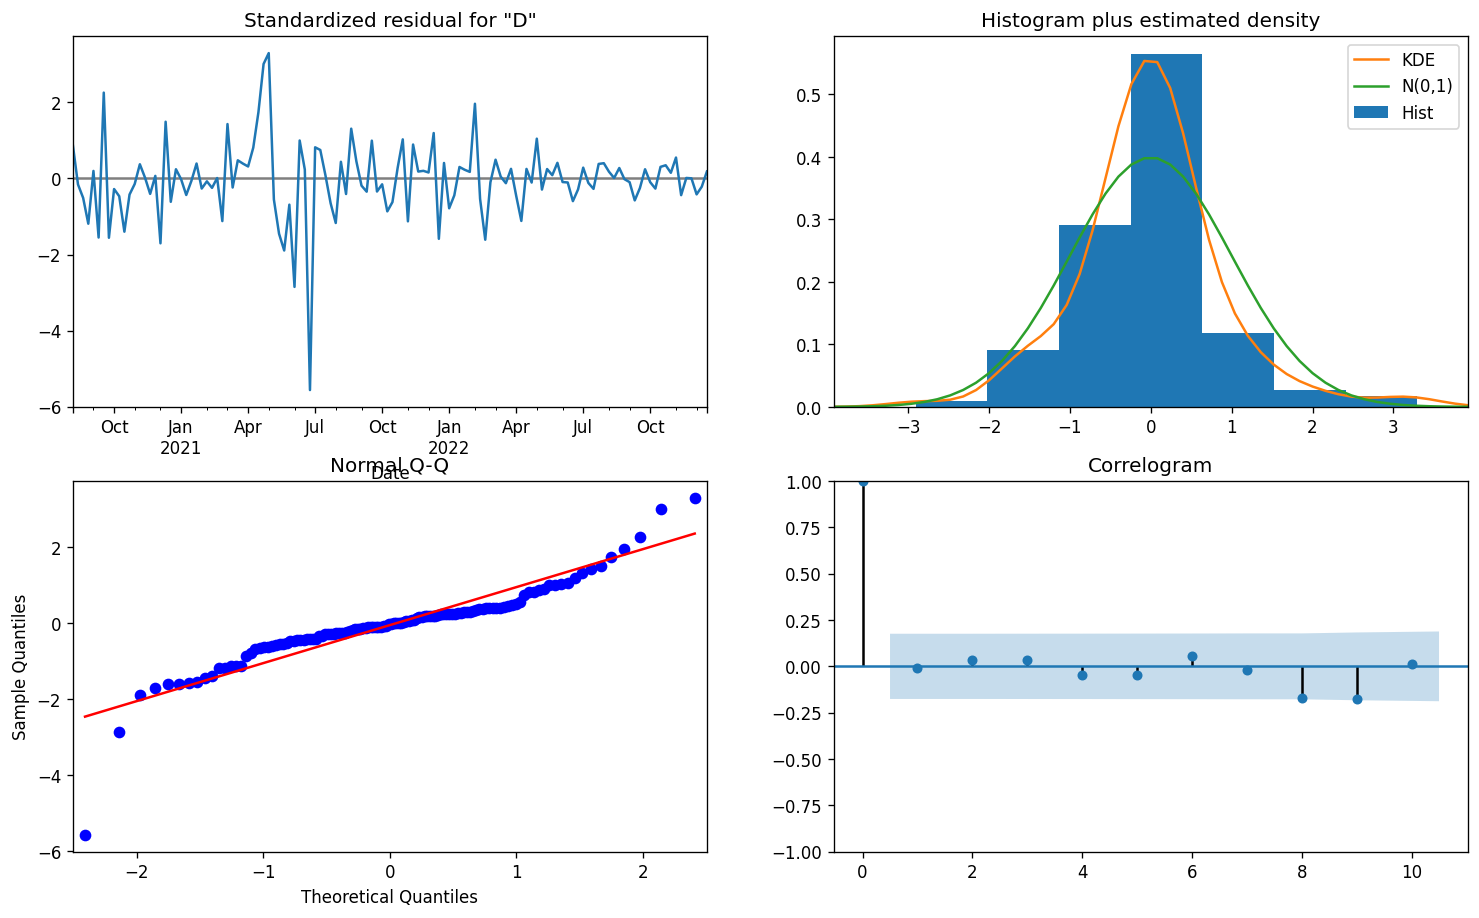

In [108]:
residuals_default = results_default.plot_diagnostics(figsize=(15, 9))

* Validating Forecasts:
We have obtained a model for our time series that can now be used to produce forecasts.

We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts

The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

* One-step ahead forecast

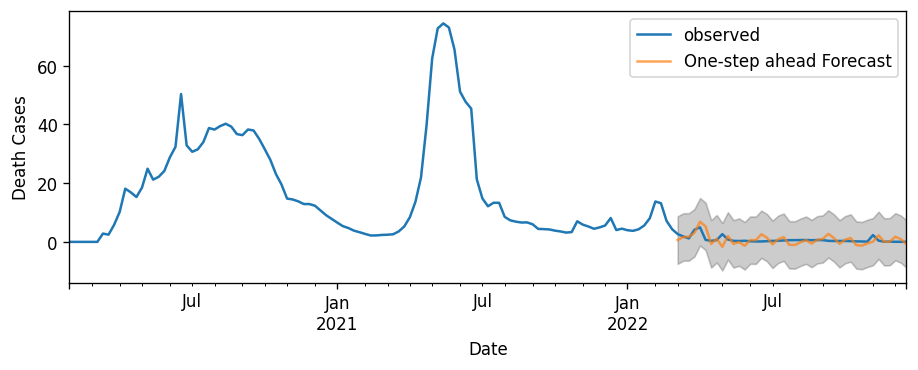

In [109]:
# Validating forecasts
# To help us understand the accuracy of our forecasts, 
# we compare predicted sales to real sales of the time series, and we set forecasts 
# to start at 2022-03-06 to the end of the data.
pred = results_default.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y.loc[:][:].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()
# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts slightly differs with the true values, but shows a downward trend starts from the 
# 1st quarter of the year and captured the seasonality toward the end of the year.

* Validating metrics

In [110]:
# Predicted sales values
y_forecasted = pred.predicted_mean
# actual sales values
y_truth = y.loc['2022-03-06':][:]

In [111]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2.36
The Root Mean Squared Error of our forecasts is 1.54


* Future forecast using SARIMA model: Producing and Visualizing future Forecasts
The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

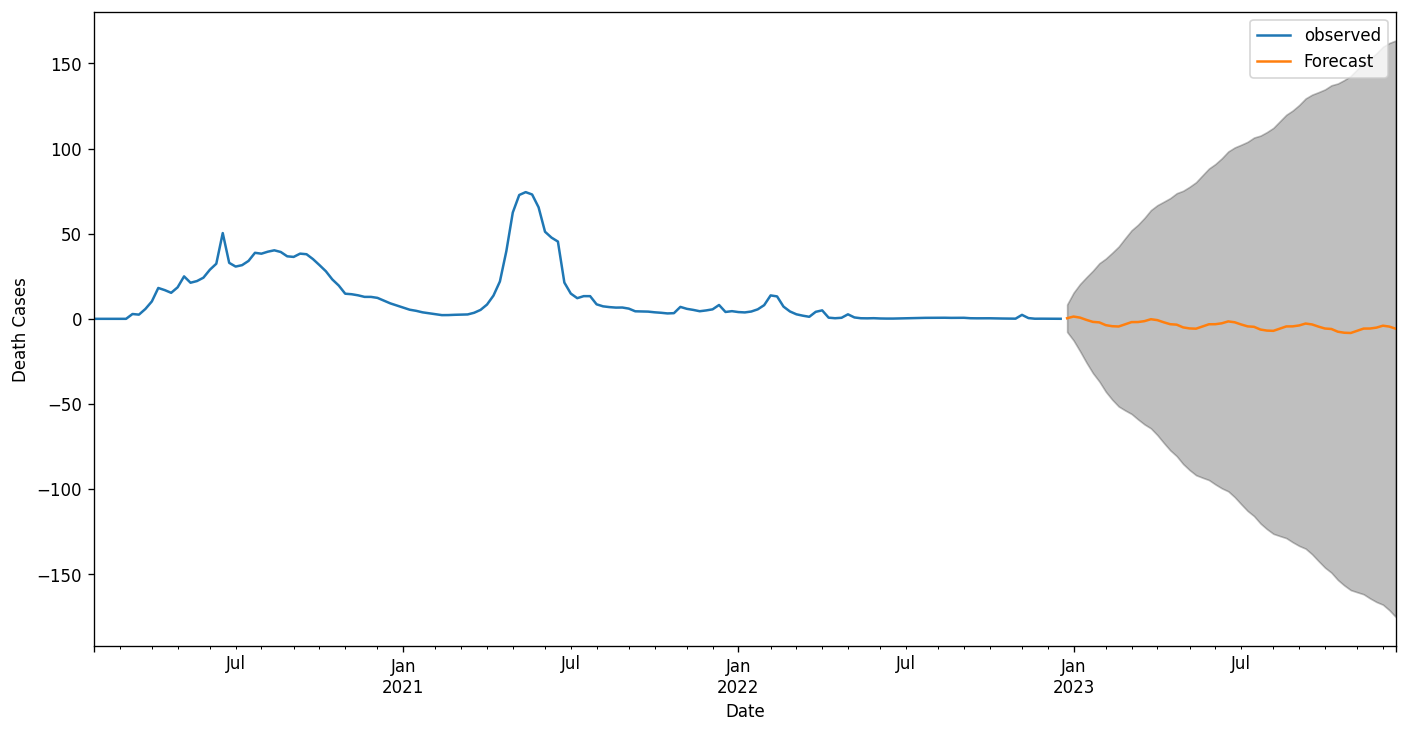

In [112]:
pred_uc = results_default.get_forecast(steps=52)
pred_ci = pred_uc.conf_int()
ax = y.loc['2020-02-02':][:].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Death Cases')
plt.legend()
plt.show()

In [113]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-12-25,0.35745948,-7.68765064,8.40256961
1,2023-01-01,1.33898386,-12.68625370,15.36422142
2,2023-01-08,0.71568274,-19.00177009,20.43313557
3,2023-01-15,-0.62690219,-25.70175096,24.44794657
4,2023-01-22,-1.79483613,-31.87457563,28.28490338
5,2023-01-29,-2.09279129,-36.83664182,32.65105923
6,2023-02-05,-3.71753064,-42.81070004,35.37563876
7,2023-02-12,-4.34041985,-47.49903607,38.81819636
8,2023-02-19,-4.49976532,-51.47054858,42.47101794
9,2023-02-26,-3.21938942,-53.77837926,47.33960043


#**ACTIVE CASES**

* From here working only on Active Cases Column along wiht date as index 

Creating a line plot for the full time series of Active Cases. Here plot() function form matplotlib package is used. Tried looking into the trend by plotting the original data alon with other line which is aggregated by the mean for monthly data. So we can find visualisation for line plot with two lines in it. 






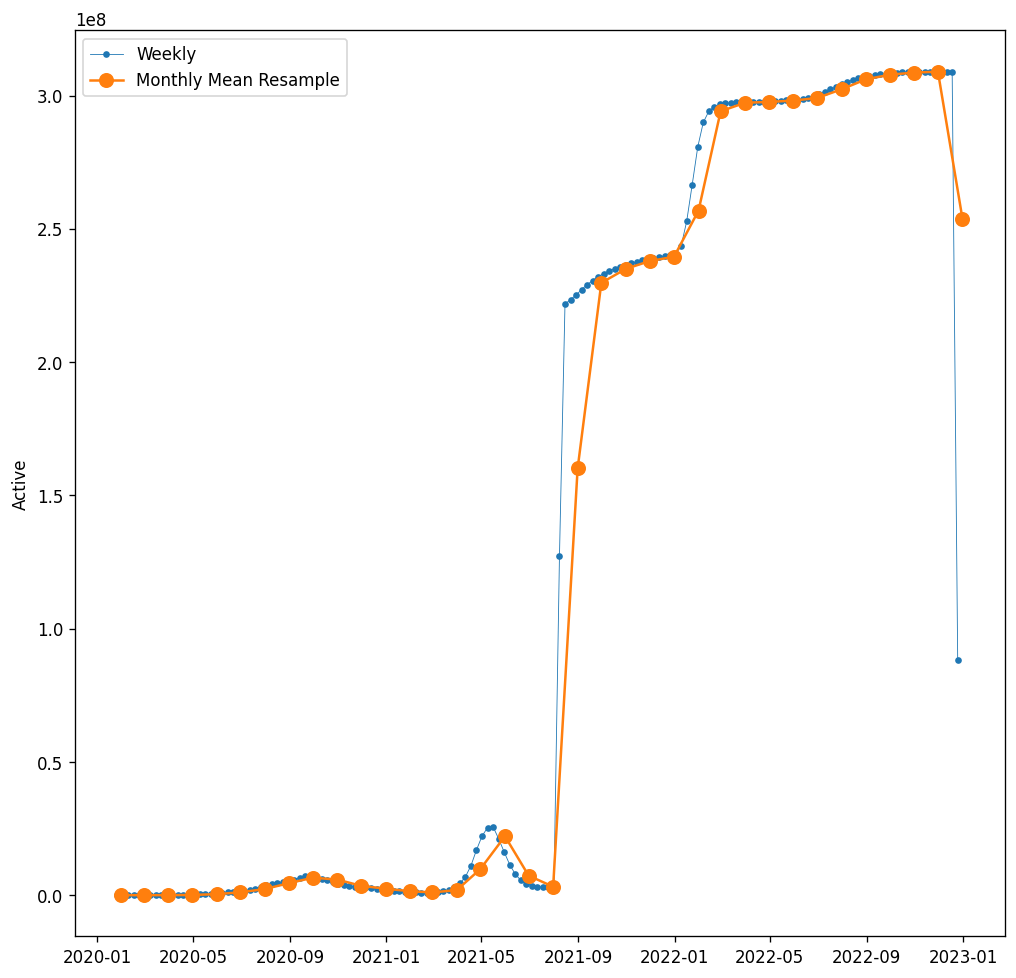

In [114]:
y = timeseries_df_India['Active']
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Active')
ax.legend();

The line graph is plotted with Active cases aggregatd for weekly and monthly along with date. If we look into the graph we can observe upward/downward trends in the data along with few anomalies. As there is no data included after December 20th, 2022 we can see a dip at the end of the line.

* Decomposition of the time series: 
The following properties will be observed from data decomposition.
*Trend: It can be seen as a slope with increase or decrease in the data.
* Sesonality: It is observed as patterns with a frequency which is affected by time period.
* Residuals: It is observed as the diffrence between obereved and predicted time series at each at a time t.



In [115]:
# graphs to show seasonal_decompose
def seasonal_decompose_func (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(8,8)
    plt.show()

Calling the function seasonal_decompose() which is created above by passing the time series as an input to the function.

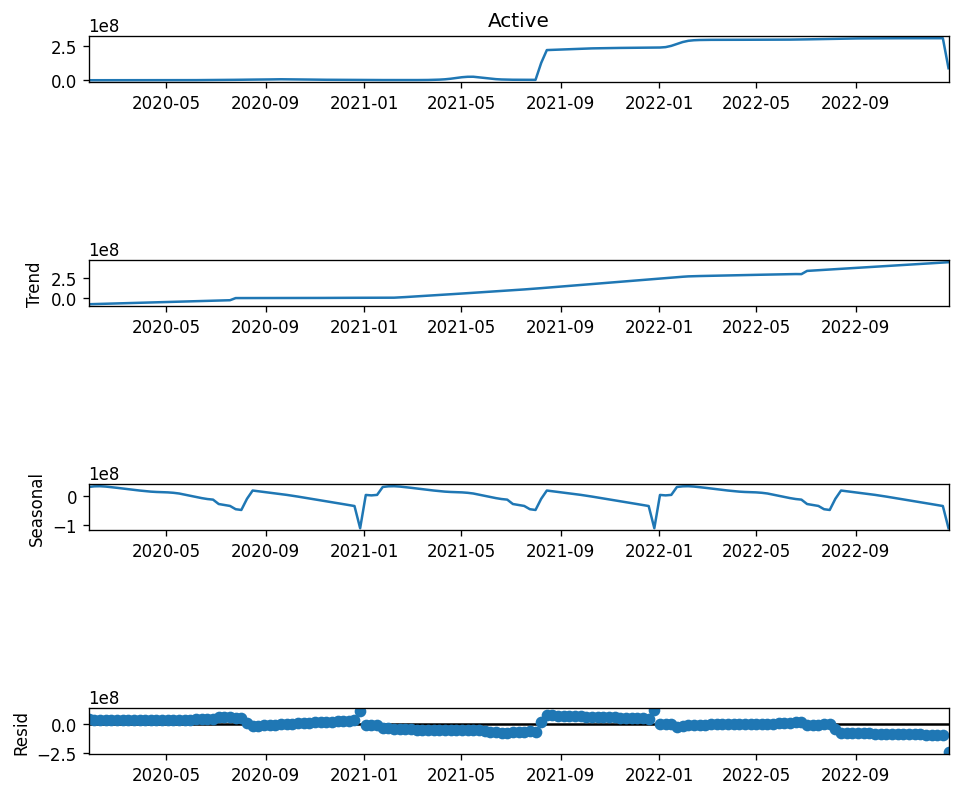

In [116]:
seasonal_decompose_func(y)

From the 4 graphs the first graph indicates the plotting of obserevd series and 2nd graph is for Trend, 3rd is for Sesionality and 4th is for Residuals. Additive model decomposition is chosen for this dataset.From the resultant trend graph it can be observed that there is an upward trend. Also in the sesonal graph we can observe that there is a sesonality for every start of the year.The residuals or the errors are also spread randomly in the Resid graph. By determing these properties of series will be helpful in choosing the time series models.

* **STATIONARITY CHECK**: 
The observations in a stationary time series are not dependent on time.
Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.


* Rolling statistics test: if time series data is required to be stationary the it should have a constant mean and variance. This indicates the mean and standard deviation or square root of variance are constant with increase in time. The rolling statistics is one of the visualisation method to visulaise the mean and standard deviation of the data.

In [117]:
### plot for Rolling Statistic for testing Stationarity
def stationarity_test(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    plt.title("Rolling mean and standard deviation")
    ax.legend()

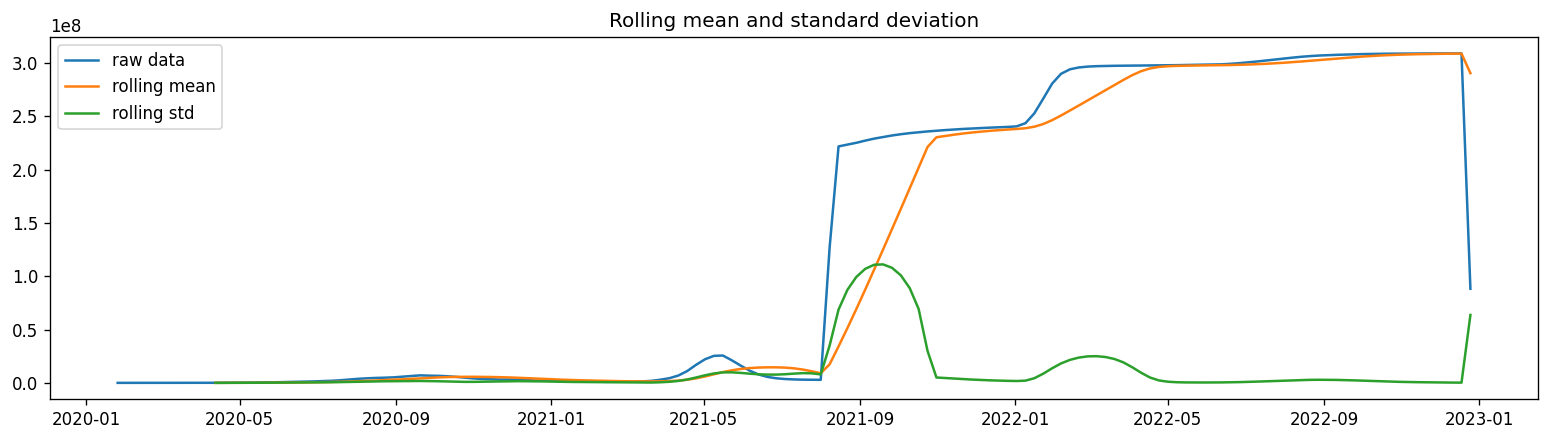

In [118]:
pd.options.display.float_format = '{:.8f}'.format
stationarity_test(y,'raw data')

After plotting the rolling statistics for the Time series data, from the resultant graph it can be observed as the rolling mean is incerasing with the increase in time and rolling standard deviation is constant with time. This indicates that the time series which we are analysing is not stationary.

* Augmented Dickey-Fuller Test:
The main reson behind conducting this test is to determing the stationarity. Here p-value <=0.05 then we can say that the null hypothesis is rejected and the data is stationary. If p-value >0.05 then it failed to reject the hypothesis and the data is not stationary.




In [119]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [120]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.463
P-value = 0.552
Critical values :
	1%: -3.4750180242954167 - The data is not stationary with 99% confidence
	5%: -2.8811408028842043 - The data is not stationary with 95% confidence
	10%: -2.577221358046935 - The data is not stationary with 90% confidence


From the output we can observe that the p-value > 0.05 and also the test statistic when compared to the critical values the test statistic value is greater. So the time series data which we used for analysis is not stationary.

* **Making the data stationary**

* Taking square root of the data: As the data for the Active cases are too large in numbers so taking square roo to those values.

In [121]:
df_sqrt=np.sqrt(timeseries_df_India['Active'])
df_diff=df_sqrt.diff().dropna()
print(df_diff)

Date
2020-02-02       2.23606798
2020-02-09       2.34650772
2020-02-16      -0.33993501
2020-02-23      -4.24264069
2020-03-01       0.00000000
                  ...      
2022-11-27       0.61293197
2022-12-04       0.40578402
2022-12-11       0.29385051
2022-12-18       0.24020229
2022-12-25   -8182.58498358
Freq: W-SUN, Name: Active, Length: 152, dtype: float64


In [122]:
# Using drop() function to delete last row
df_diff.drop(index=df_diff.index[-1],axis=0,inplace=True)
print(df_diff)
y = df_diff

Date
2020-02-02    2.23606798
2020-02-09    2.34650772
2020-02-16   -0.33993501
2020-02-23   -4.24264069
2020-03-01    0.00000000
                 ...    
2022-11-20    1.06784636
2022-11-27    0.61293197
2022-12-04    0.40578402
2022-12-11    0.29385051
2022-12-18    0.24020229
Freq: W-SUN, Name: Active, Length: 151, dtype: float64


* Deseasonalising: It removes the underlying seasonaity from the time series. 

 > Is the de-seasonalized data stationary ?
Test statistic = -10.003
P-value = 0.000
Critical values :
	1%: -3.4750180242954167 - The data is  stationary with 99% confidence
	5%: -2.8811408028842043 - The data is  stationary with 95% confidence
	10%: -2.577221358046935 - The data is  stationary with 90% confidence


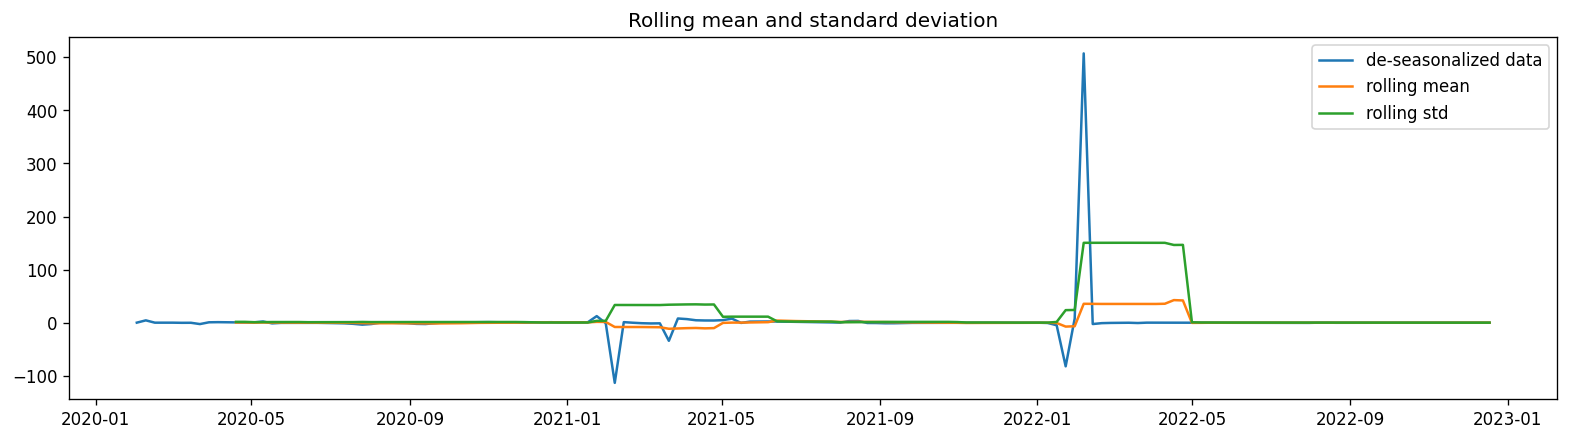

In [123]:
# Deseasonalize
result_add = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq')
deseasonlize = y.values / result_add.seasonal
# rolling statistics test
stationarity_test(deseasonlize,'de-seasonalized data')
#ADF test
ADF_test(deseasonlize,'de-seasonalized data')

From the plots we can observe that the mean and standard deviation had become constant with time and the test statistic values are also greater than the critical calues. So we can conclude from this that the time series data had become stationary after removing the sesonal component

**ARIMA**:
ARIMA is an Auto Regressive Integrated Moving Average.
It is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. ARIMA model accepts the non-sesasonal time series. So for this model we are removing the seasonality by taking the deseasonal time series which are computed above.

* Finding order of differencing(d) in ARIMA model: The purpose of differencing it to make the time series stationary.

But we need to be careful to not over-difference the series. Because, an over differenced series may still be non-stationary, which in turn will affect the model parameters.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing.



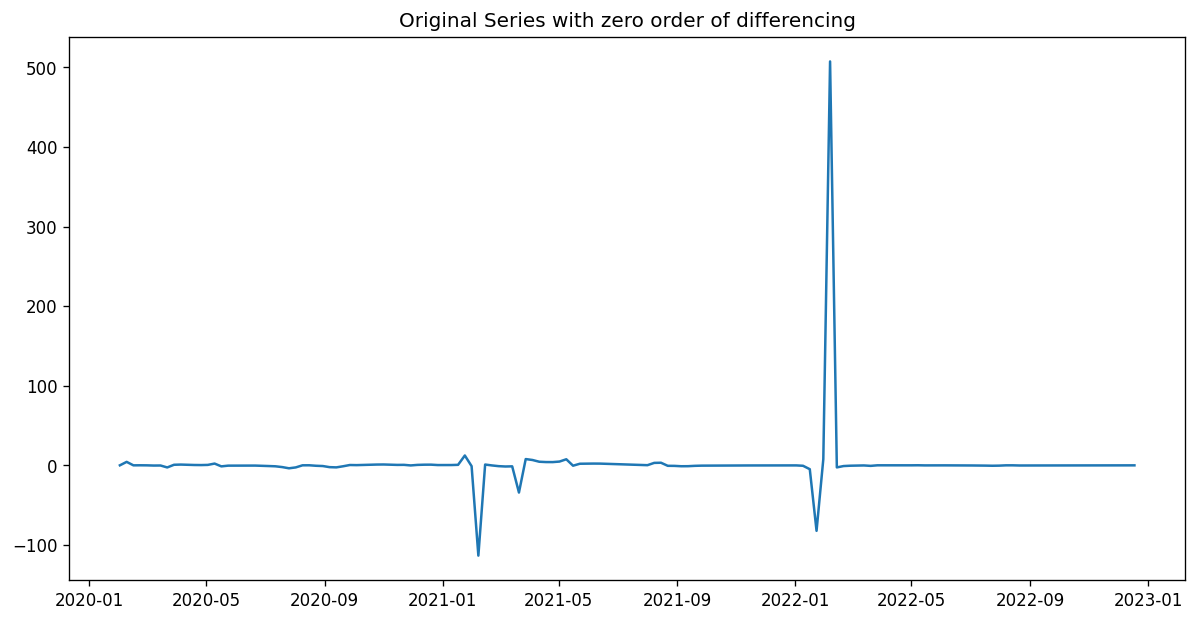

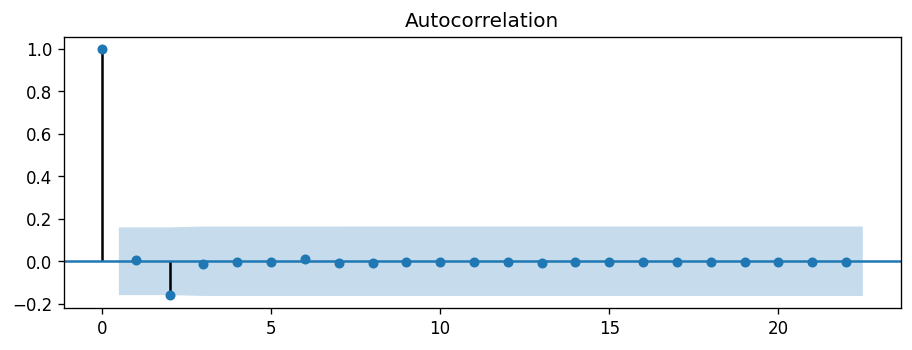

In [124]:
# Original Series
y_deseasonal = deseasonlize
plt.figure(figsize=(12, 6))
plt.plot(y_deseasonal)
plt.title('Original Series with zero order of differencing')
acf0 = plot_acf(y_deseasonal)

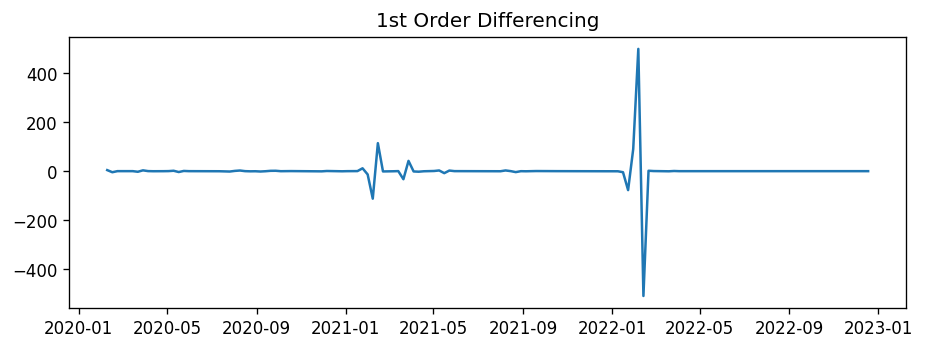

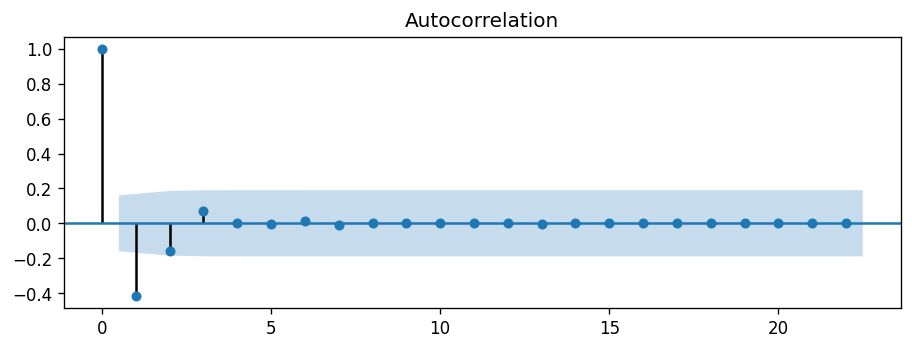

In [125]:
# 1st order Differencing
plt.plot(y_deseasonal.diff()); 
plt.title('1st Order Differencing')
acf1 = plot_acf(y_deseasonal.diff().dropna())


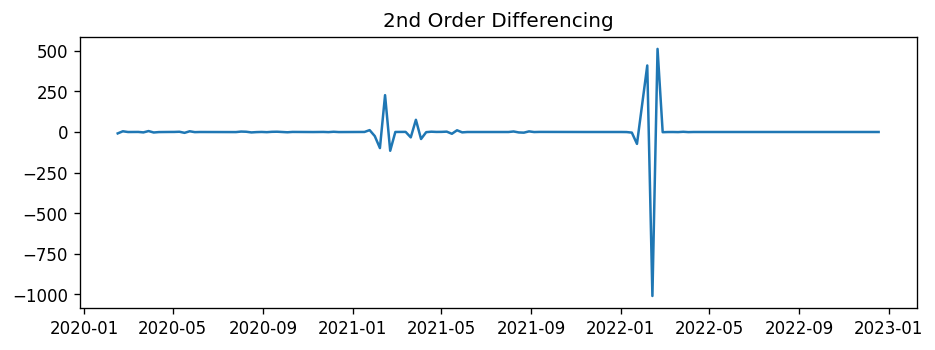

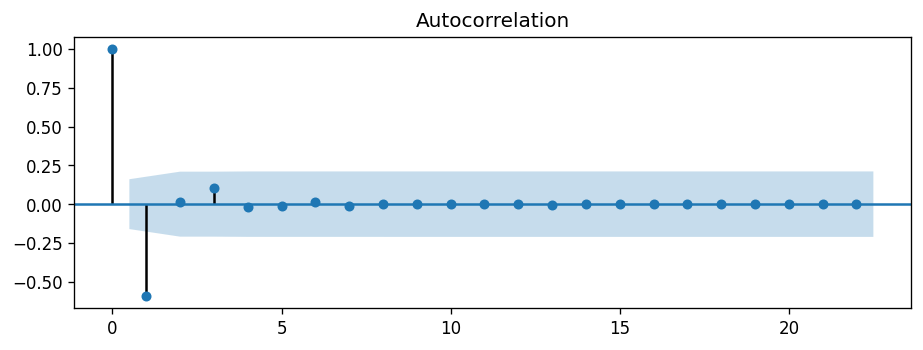

In [126]:
# 2nd order Differencing
plt.plot(y_deseasonal.diff().diff()); 
plt.title('2nd Order Differencing')
acf2 = plot_acf(y_deseasonal.diff().diff().dropna())

From the resultant plots we can observe that the ACF plot reaches to 0 at the zero order difference itself. So we are considering d value which is orderof diffrencing as d = 0 for this time series.

* Deternming AR(p)

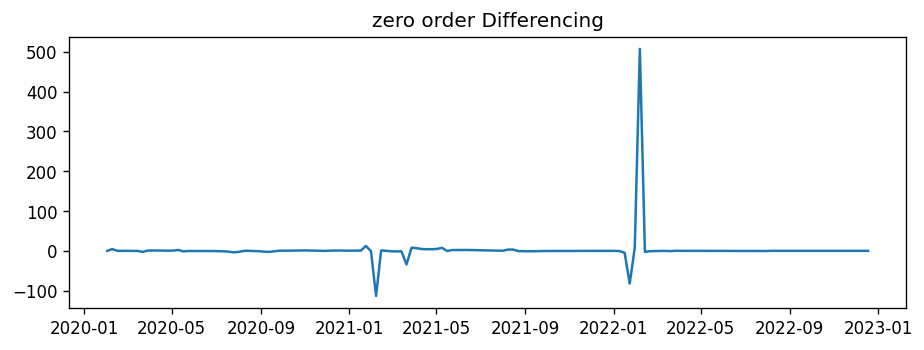

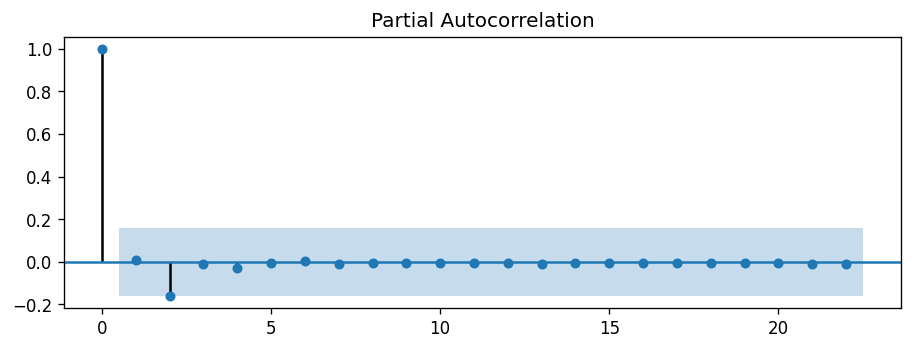

In [127]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
pacf = plot_pacf(y_deseasonal.dropna())

* Determining MA(q)

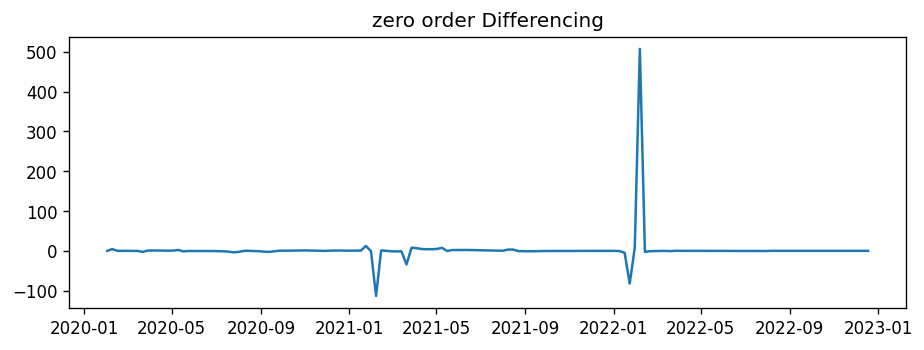

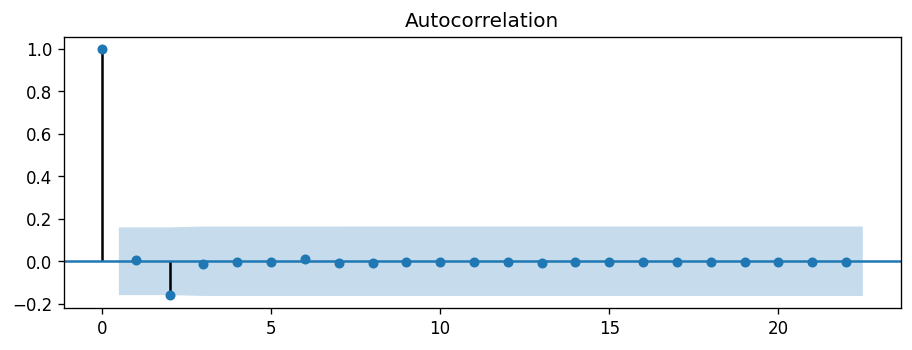

In [128]:
plt.plot(y_deseasonal); 
plt.title('zero order Differencing')
acf = plot_acf(y_deseasonal.dropna())

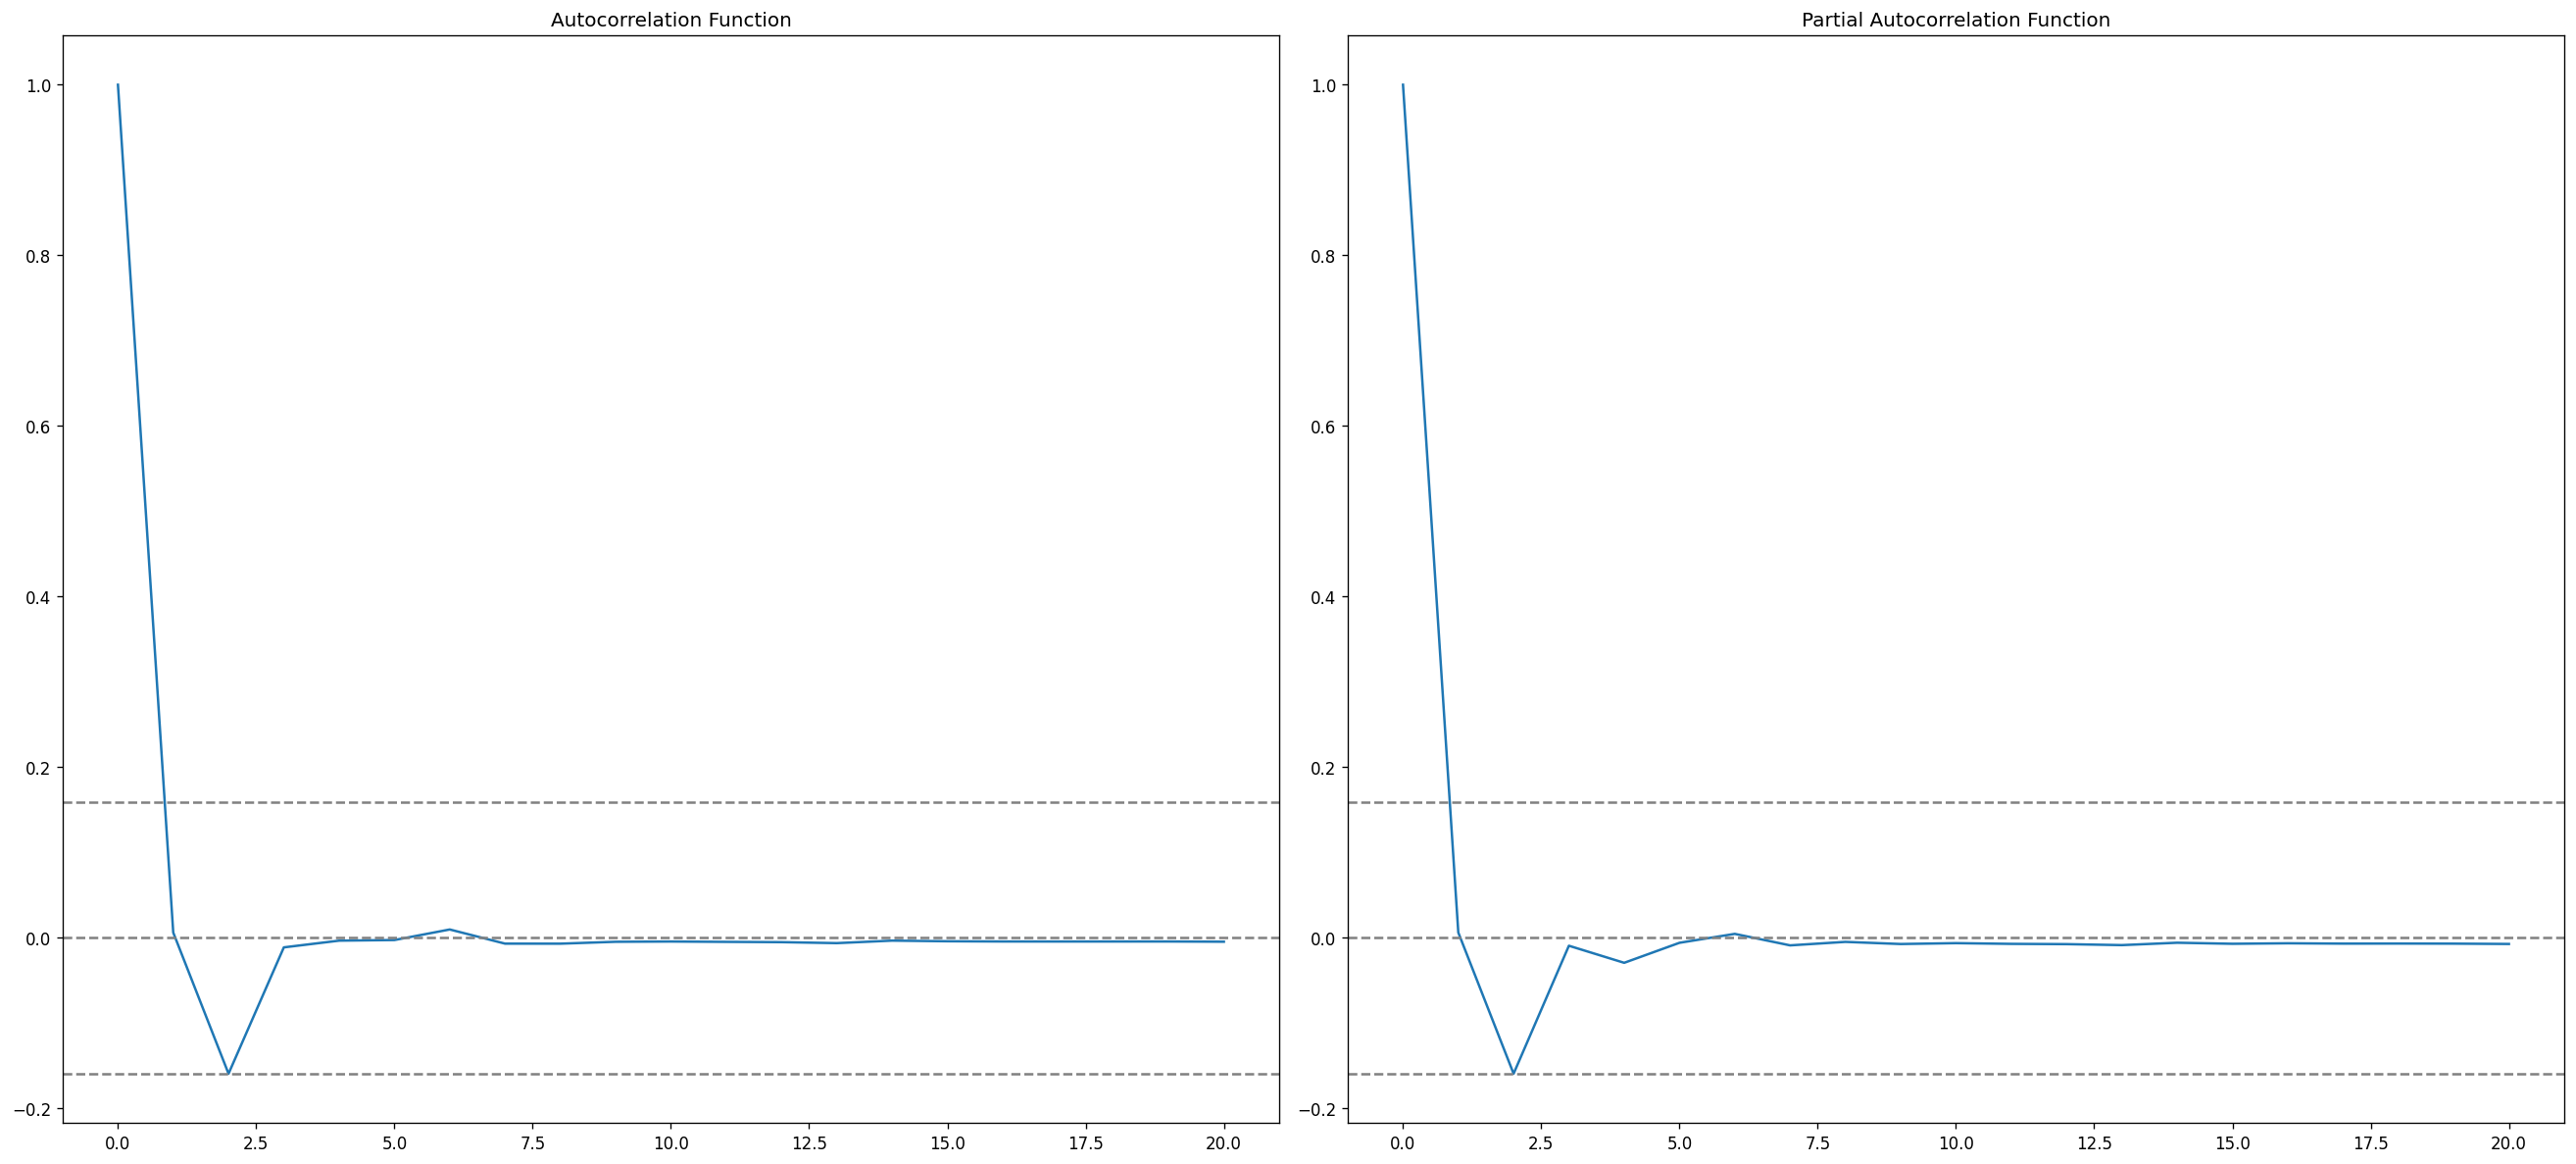

In [129]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(y_deseasonal, nlags=20)
lag_pacf = pacf(y_deseasonal, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_deseasonal)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Two dotted lines are the confidence interevals. We use these lines to determine the ‘p’ and ‘q’ values
Choosing p: The lag value where the PACF chart crosses the upper confidence interval for the first time which is close to 1. p=1.
Choosing q: The lag value where the ACF chart crosses the upper confidence interval for the first time which is close to 1. q=1.

In [130]:
model = ARIMA(y_deseasonal, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               seasonal   No. Observations:                  151
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -781.390
Date:                Tue, 17 Jan 2023   AIC                           1570.779
Time:                        07:47:25   BIC                           1582.848
Sample:                    02-02-2020   HQIC                          1575.682
                         - 12-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2006     10.718      0.205      0.837     -18.806      23.208
ar.L1         -0.6367      1.716     -0.371      0.711      -4.000       2.727
ma.L1          0.7024      1.702      0.413      0.6

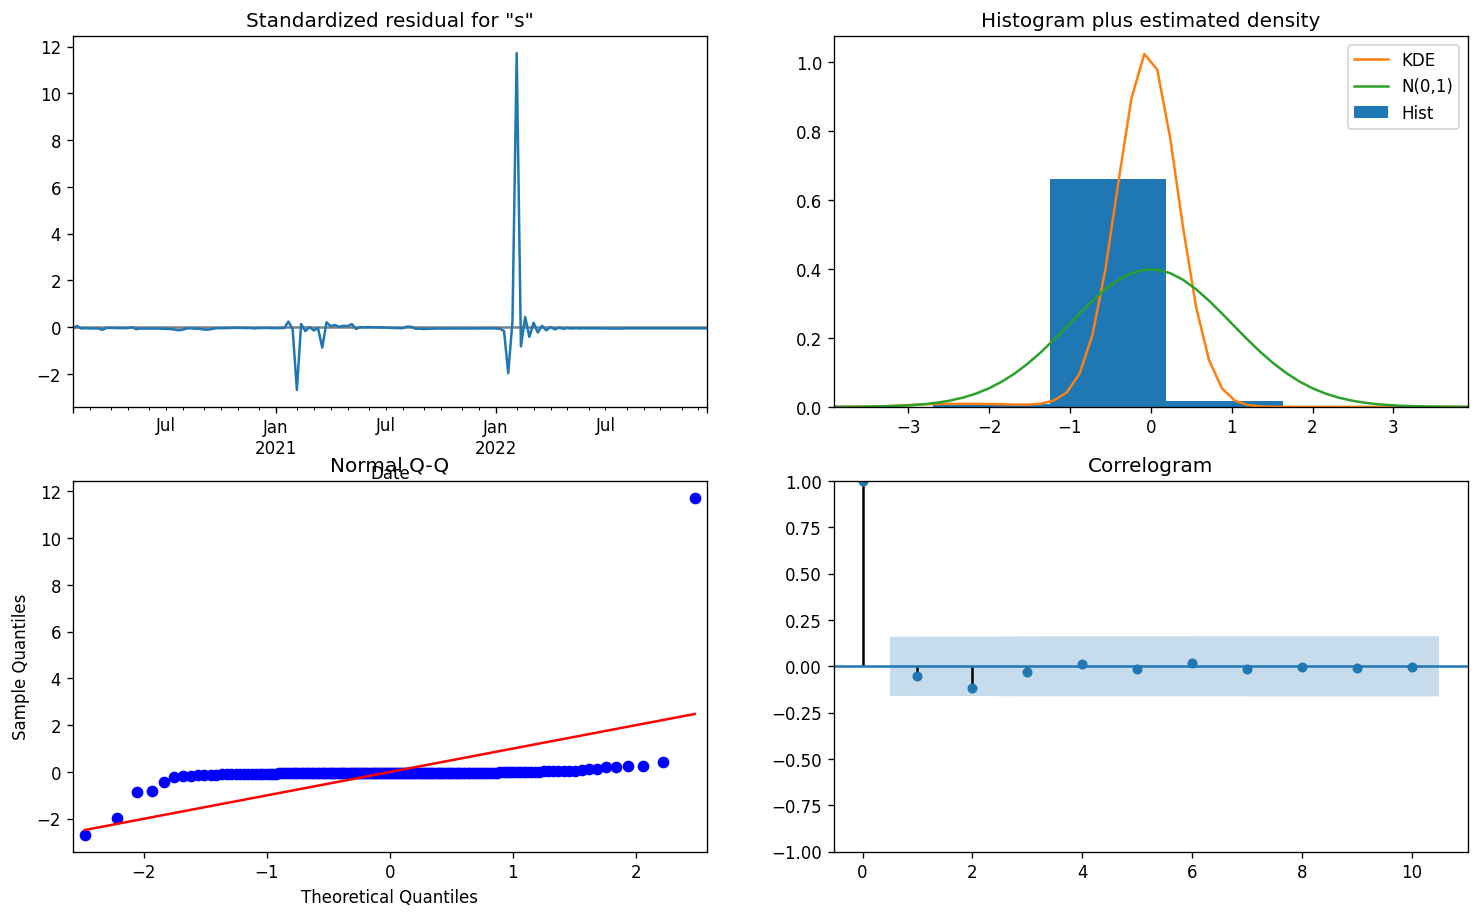

In [131]:
residuals_default = model_fit.plot_diagnostics(figsize=(15, 9))

* One-step ahead forecast

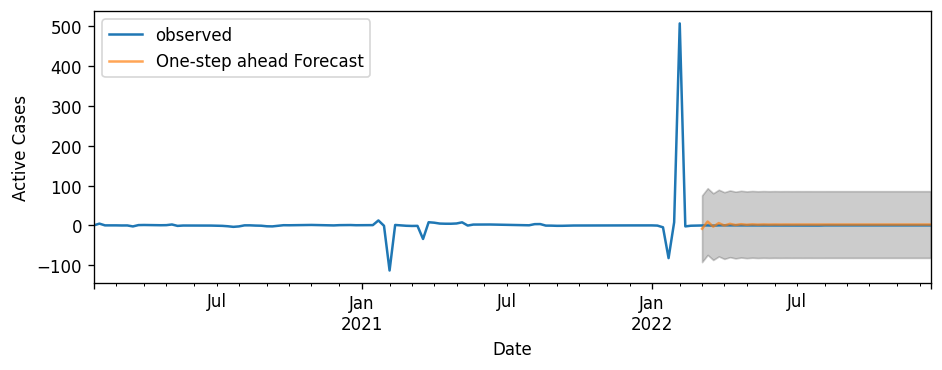

In [132]:
# Validating forecasts
# To help us understand the accuracy of our forecasts, 
# we compare predicted sales to real sales of the time series, and we set forecasts 
# to start at 2022-03-06 to the end of the data.
pred = model_fit.get_prediction(start=pd.to_datetime('2022-03-06'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_deseasonal.loc[:][:].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Active Cases')
plt.legend()
plt.show()
# The line plot is showing the observed values compared to the rolling forecast predictions. 
# Overall, our forecasts slightly differs with the true values, but shows a downward trend starts from the 
# 1st quarter of the year and captured the seasonality toward the end of the year.

* Forecasting Active cases with ARIMA model

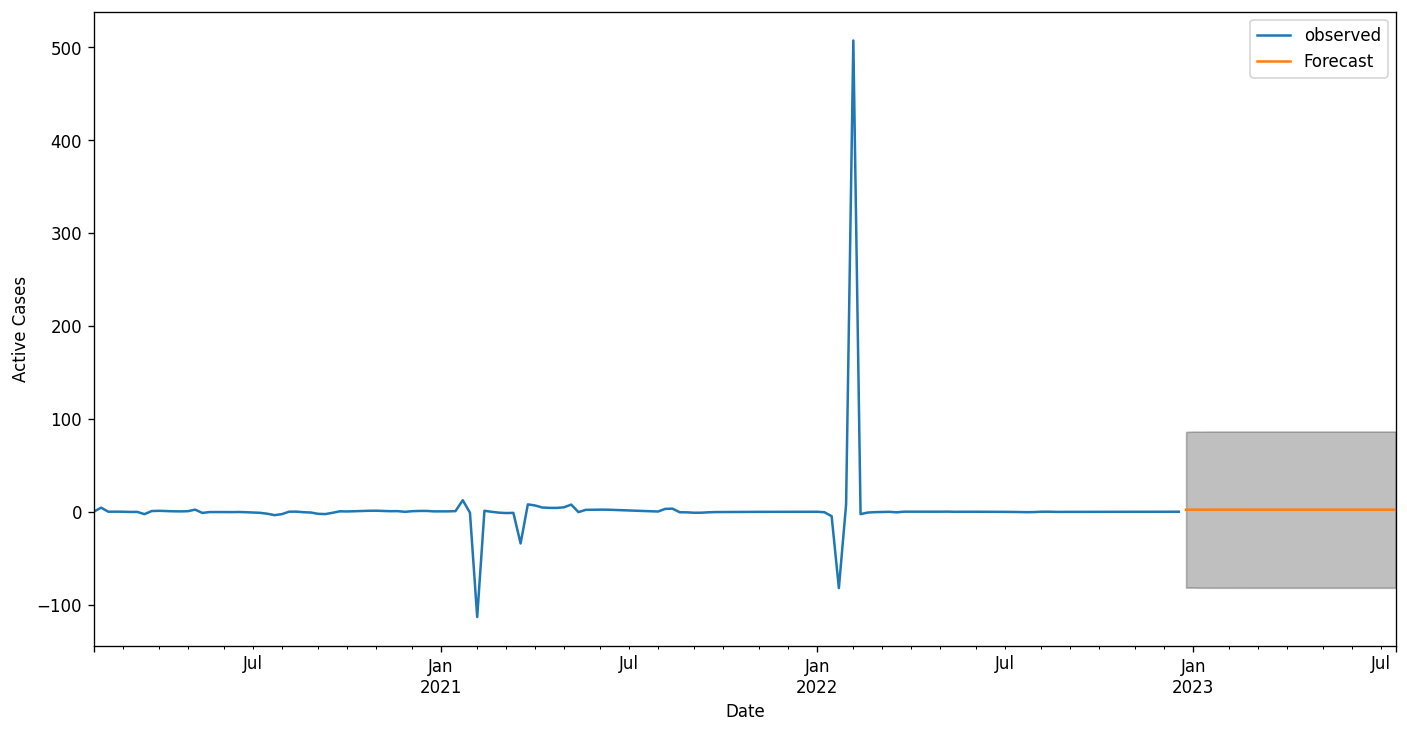

In [133]:
pred_uc = model_fit.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y_deseasonal.loc['2020-02-02':][:].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Active Cases')
plt.legend()
plt.show()

In [134]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2022-12-25,2.11554875,-81.70738583,85.93848332
1,2023-01-01,2.25477881,-81.74921103,86.25876866
2,2023-01-08,2.16613674,-81.91113004,86.24340351
3,2023-01-15,2.22257151,-81.88437877,86.32952179
4,2023-01-22,2.18664180,-81.93233724,86.30562085
5,2023-01-29,2.20951678,-81.91433746,86.33337101
6,2023-02-05,2.19495322,-81.93087702,86.32078346
7,2023-02-12,2.20422524,-81.92240593,86.33085640
8,2023-02-19,2.19832212,-81.92863368,86.32527793
9,2023-02-26,2.20208040,-81.92500700,86.32916779
